In [1]:
library(readxl)
library(tidyverse)
library(writexl)
library(plm)
library(dplyr)
library(tsibble)
library(fpp3)
library(panelvar)
library(lpirfs)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'plm'


The following objects are masked from 'package:dplyr':

    between, lag, lead


Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: 'tsibble'


The following object is masked from 'package:plm':

    index


The following object is masked from 'package:lubridate':

    interval


The following objects are masked from 'package:base':

    intersect, setdiff, union


-- At

In [2]:
library(arrow)

# Read the Parquet file
quart_df <- read_parquet("/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/purchases_paper/datasets/final_data_mun.parquet")



Attaching package: 'arrow'


The following object is masked from 'package:lubridate':

    duration


The following object is masked from 'package:utils':

    timestamp




## Shocks in Series

In [3]:
endog        <- c("purchases_log_D1", "ur_D1", "hpi_log_D1")
exo_base     <- c(                       # contemporaneous exogenous terms
  "fwi_D1", "high_fire_days", "tp_hd",
  "tp_std_mm_hour_D1", "t2m_hd", "t2m_std_D1", "Medit_factor_tp",
"Medit_factor_t2m_D1"
)
## ---------------- 3. prepare the master data frame -------------------------
df_panel <- quart_df %>% 
  arrange(CCA_2, time)
df_tmp <-  df_panel  %>% 
  mutate(time = yearquarter(time)) %>%  select(CCA_2, time, all_of(endog), all_of(exo_base)) 

# Step 1: Create linear trends that are specific to each municipality
df_tmp <- df_tmp %>%
  group_by(CCA_2) %>%
  mutate(Linear_Trend = row_number())  # Creates a linear trend for each municipality

# Step 2: Create quadratic trends that are specific to each municipality
df_tmp <- df_tmp %>%
  mutate(Quadratic_Trend = Linear_Trend^2)  # Quadratic trend is square of linear trend

                                  # no missing values
df_tmp_df <- as.data.frame(df_tmp)


In [4]:
df_ts <- df_tmp_df  %>%  select(CCA_2, everything())
df_as_dataframe <- as.data.frame(df_ts)

In [6]:
# Iterate over each combination of endog_data and shock
library(glue)
endog        <- c("purchases_log_D1", "ur_D1", "hpi_log_D1")
shock     <- c(                       # contemporaneous exogenous terms
  "fwi_D1", "high_fire_days", "tp_hd",
  "tp_std_mm_hour_D1", "t2m_hd", "t2m_std_D1", "Medit_factor_tp",
"Medit_factor_t2m_D1"
)

c_exog_data <- c('Quadratic_Trend' , 'Linear_Trend')                
for (endog_var in endog) {
    for (shock_var in exo_base) {
    
    # Prepare c_exog_data: endog_data without the current endog_var
    c_exog_data_endog_removed <- setdiff(endog, endog_var)
    l_exog_data_removed <- setdiff(exo_base, shock_var)
    c_exog_complete <- c(c_exog_data_endog_removed, c_exog_data)

    # Calculate lp_lin_panel
    result <- lp_lin_panel(data_set = df_tmp_df, data_sample = 'Full',  
                            endog = endog_var, shock = shock_var, 
                            diff_shock=FALSE, cumul_mult = TRUE, 
                            panel_model = "within", panel_effect = "individual", iv_reg = FALSE, instrum = FALSE, use_gmm = FALSE, 
                            c_exog_data = c_exog_complete, 
                            l_exog_data = l_exog_data_removed, 
                              lags_exog_data = 2, confint = 1.67, hor = 12)

    print(glue('Effect of Shock of {shock_var} on {endog_var} - Values'))
    print(result$irf_panel_mean)
    }
}


Effect of Shock of fwi_D1 on purchases_log_D1 - Values
            [,1]        [,2]        [,3]         [,4]        [,5]        [,6]
[1,] 0.003913241 0.006784188 0.008347897 0.0001904306 0.002322466 0.004226132
            [,7]         [,8]        [,9]       [,10]        [,11]        [,12]
[1,] 0.006815087 -0.005054005 0.004552342 0.007734761 -0.002152026 0.0005598981
Effect of Shock of high_fire_days on purchases_log_D1 - Values
            [,1]         [,2]        [,3]        [,4]        [,5]        [,6]
[1,] 0.008758932 -0.000605176 0.001920751 0.006306109 0.004739807 0.002087661
            [,7]        [,8]        [,9]        [,10]       [,11]        [,12]
[1,] 2.62958e-06 0.000427203 0.003728617 -0.003031387 0.000407481 0.0001326435
Effect of Shock of tp_hd on purchases_log_D1 - Values
            [,1]        [,2]        [,3]       [,4]        [,5]        [,6]
[1,] -0.03000582 -0.02156185 -0.04131039 0.01654468 -0.01909704 -0.02676055
            [,7]        [,8]        [,9]      

In [8]:
library(ggplot2)
library(tidyr)
library(glue)

plot_irf_lp <- function(lp_output, shock_var, endog_var) {
    # Assuming lp_output is the result from lp_lin_panel function
    horizons <- 1:ncol(lp_output$irf_panel_mean)

    # Convert the matrices into a long data frame
    df <- data.frame(horizon = horizons,
                    mean = as.numeric(lp_output$irf_panel_mean),
                    lower = as.numeric(lp_output$irf_panel_low),
                    upper = as.numeric(lp_output$irf_panel_up))

    # Using ggplot2 to plot
    plot_irf <- ggplot(df, aes(x = horizon)) +
      geom_ribbon(aes(ymin = lower, ymax = upper), fill = "#90ffad", alpha = 0.5) +  # Confidence interval
      geom_line(aes(y = mean), color = "#002c59", linewidth = 1) +  # Mean line; 'size' changed to 'linewidth'
      labs(x = "Quarters", y = '') +
      theme_gray() +
      theme(
        plot.title = element_text(size = 20),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.line = element_line(color = "black"),  # Make x and y axis lines solid black
        axis.ticks = element_line(color = "black"),  # Make axis ticks black
        plot.margin = margin(10, 10, 5, 5,unit = 'mm')  # Add margins; top, right, bottom, left
      ) +
      scale_x_continuous(breaks = 1:max(df$horizon),   # Set breaks at every integer
                        labels = as.character(1:max(df$horizon)), # Ensure labels are characters to prevent scientific notation
                        limits = c(1, max(df$horizon))) # Set limits to prevent partial values

    return (plot_irf)
}


[1] "endog var"
[1] "purchases_log_D1"
[1] "fwi_D1"
[1] "endog var"
[1] "purchases_log_D1"
[1] "high_fire_days"


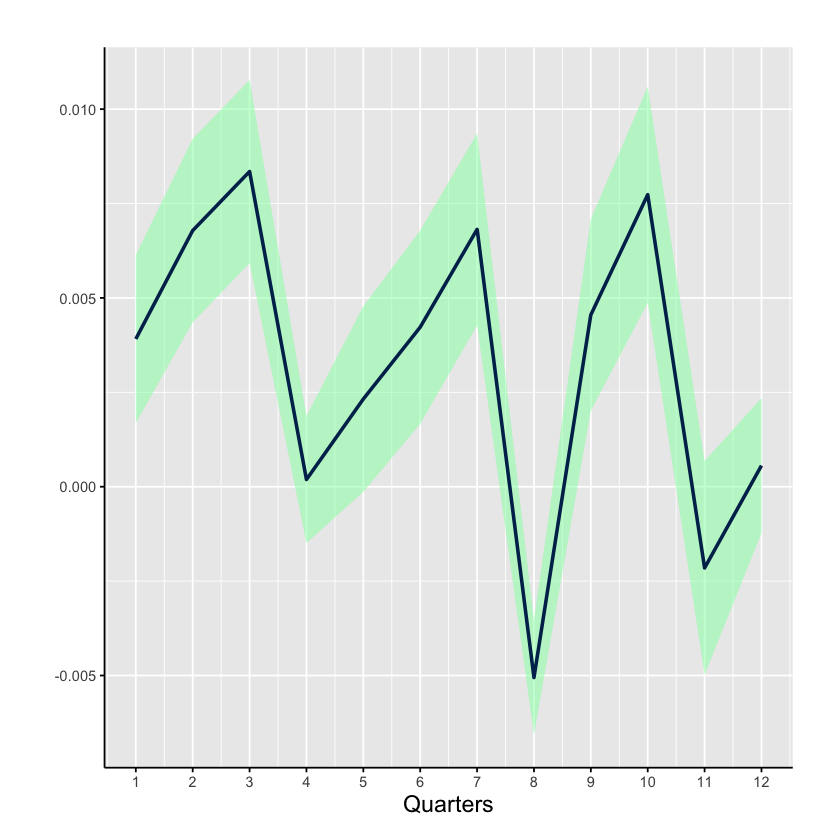

[1] "endog var"
[1] "purchases_log_D1"
[1] "tp_hd"


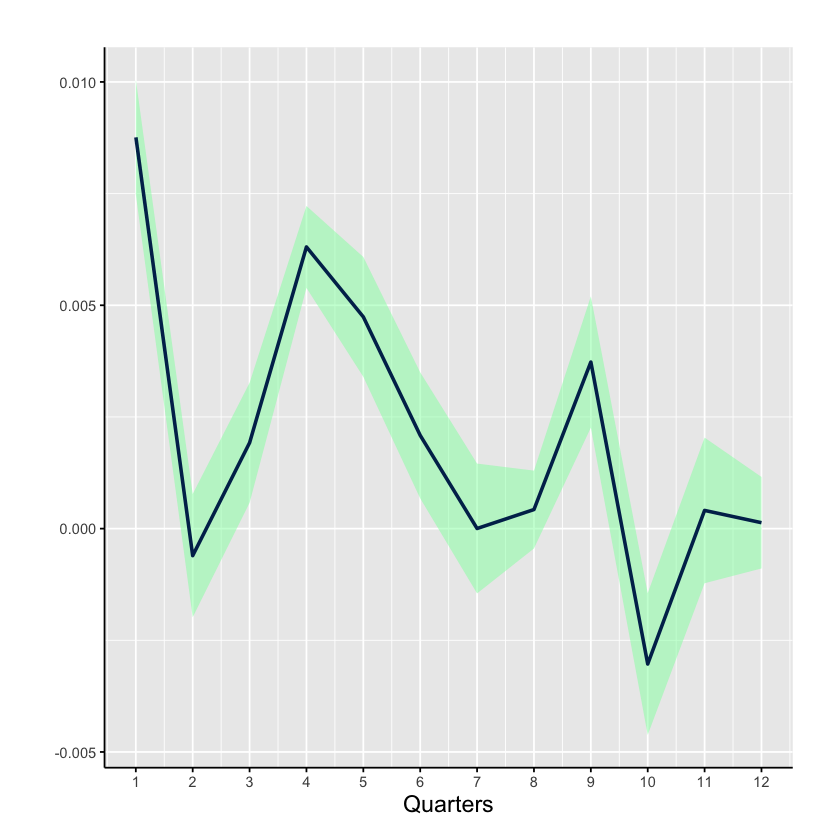

[1] "endog var"
[1] "purchases_log_D1"
[1] "tp_std_mm_hour_D1"


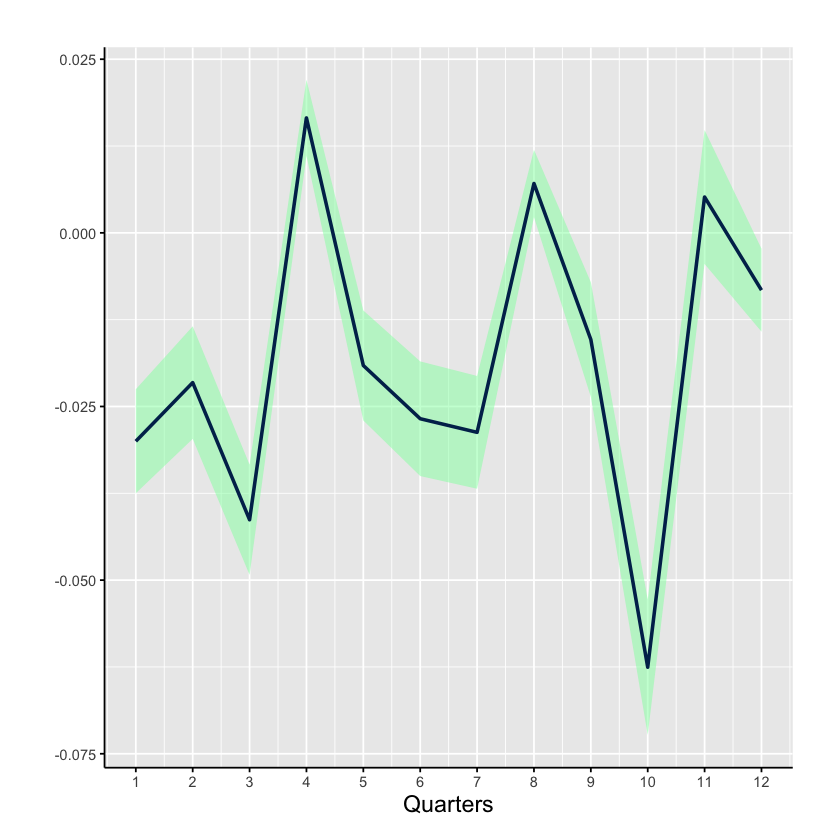

[1] "endog var"
[1] "purchases_log_D1"
[1] "t2m_hd"


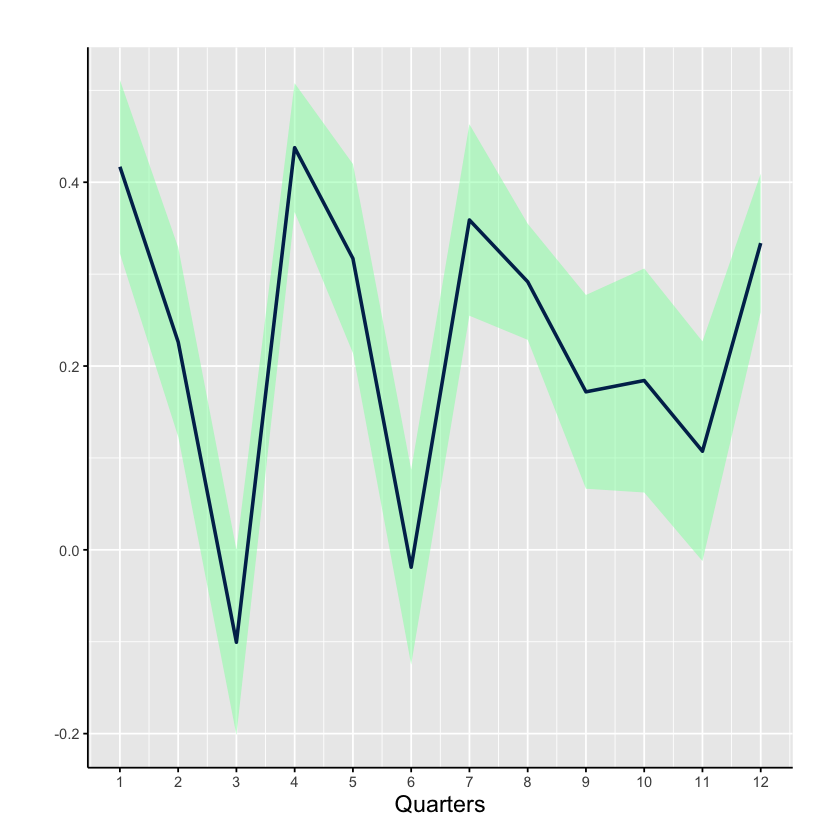

[1] "endog var"
[1] "purchases_log_D1"
[1] "t2m_std_D1"


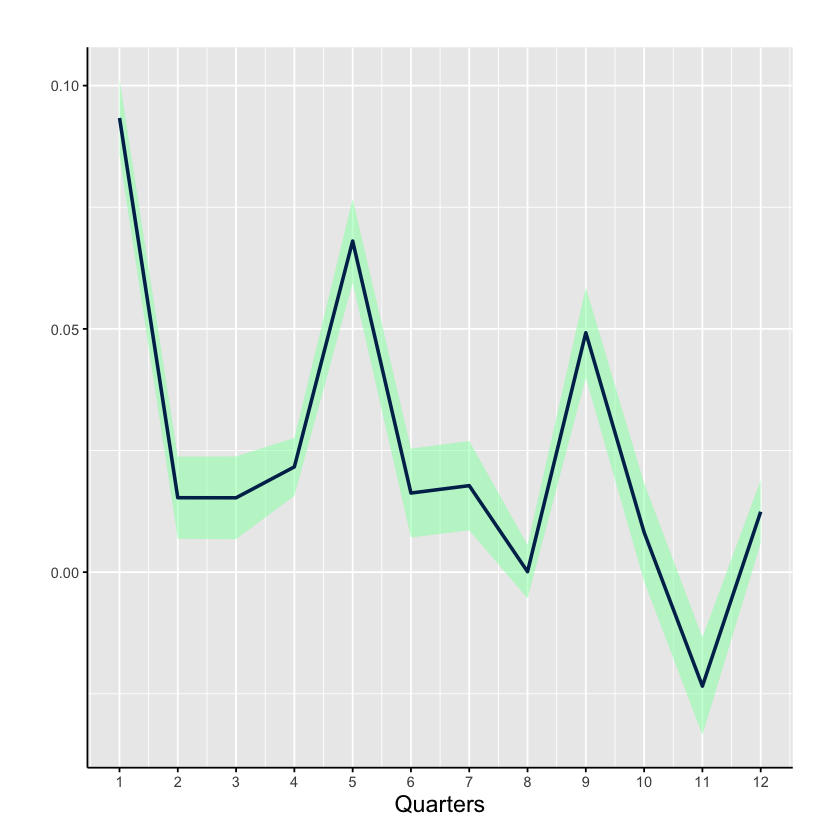

[1] "endog var"
[1] "purchases_log_D1"
[1] "Medit_factor_tp"


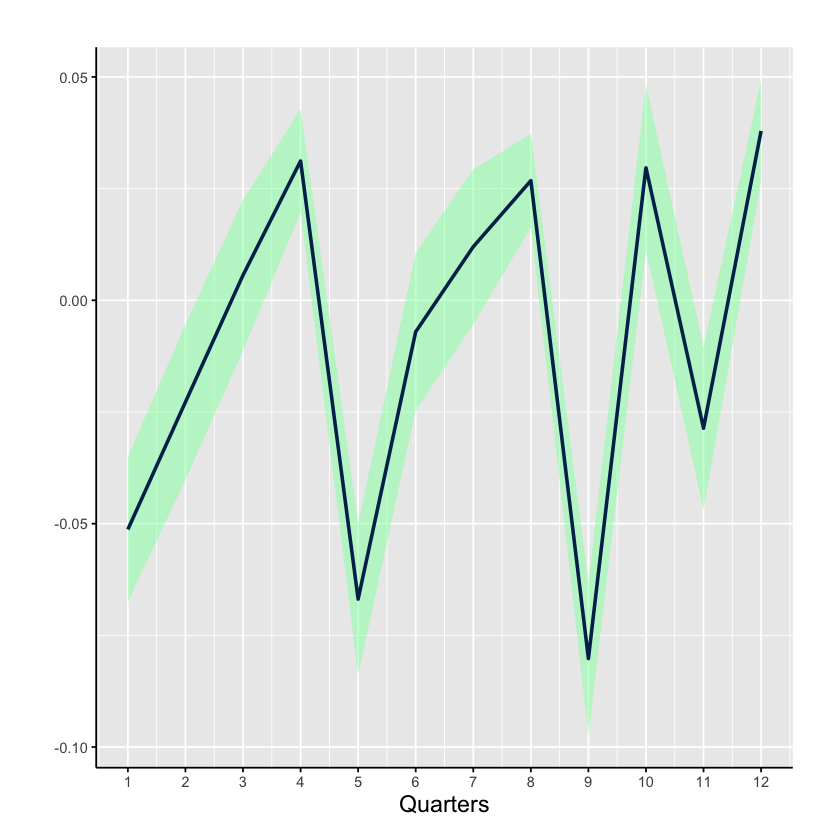

[1] "endog var"
[1] "purchases_log_D1"
[1] "Medit_factor_t2m_D1"


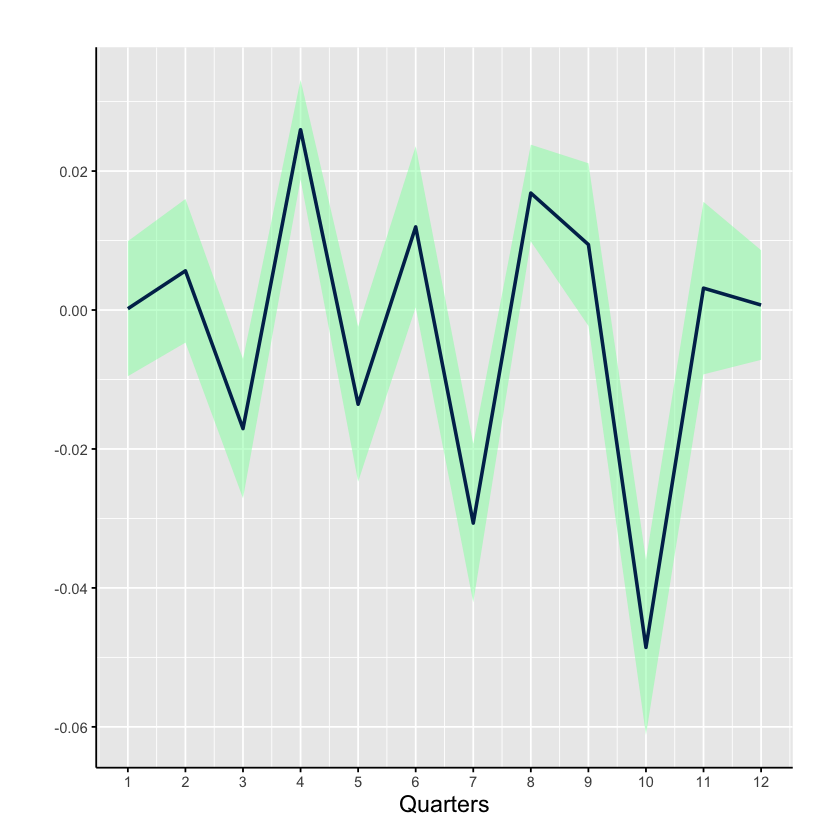

[1] "endog var"
[1] "ur_D1"
[1] "fwi_D1"


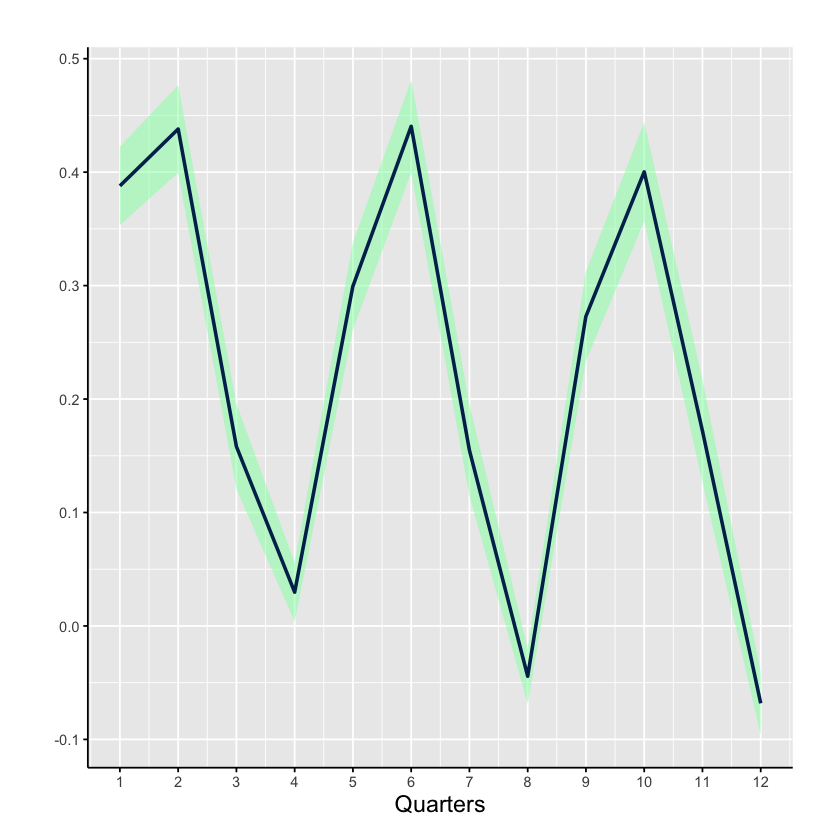

[1] "endog var"
[1] "ur_D1"
[1] "high_fire_days"


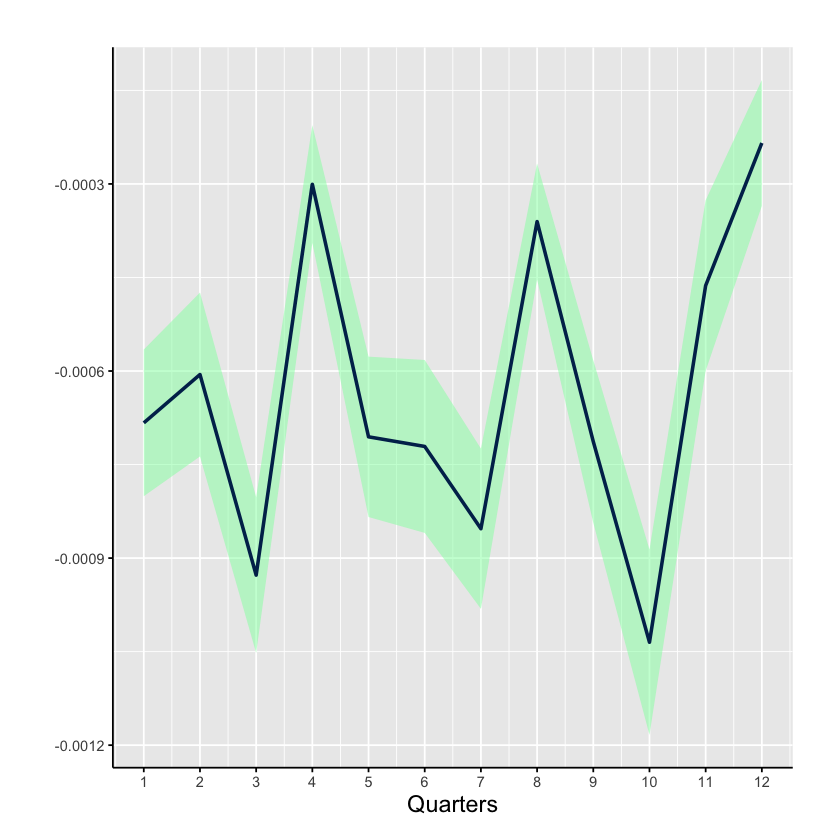

[1] "endog var"
[1] "ur_D1"
[1] "tp_hd"


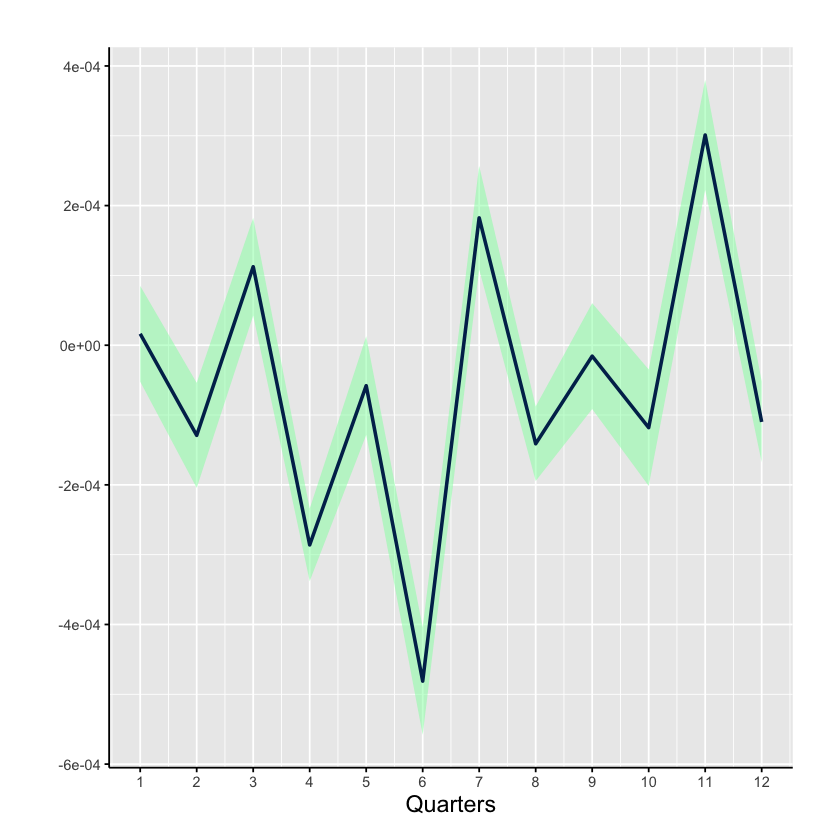

[1] "endog var"
[1] "ur_D1"
[1] "tp_std_mm_hour_D1"


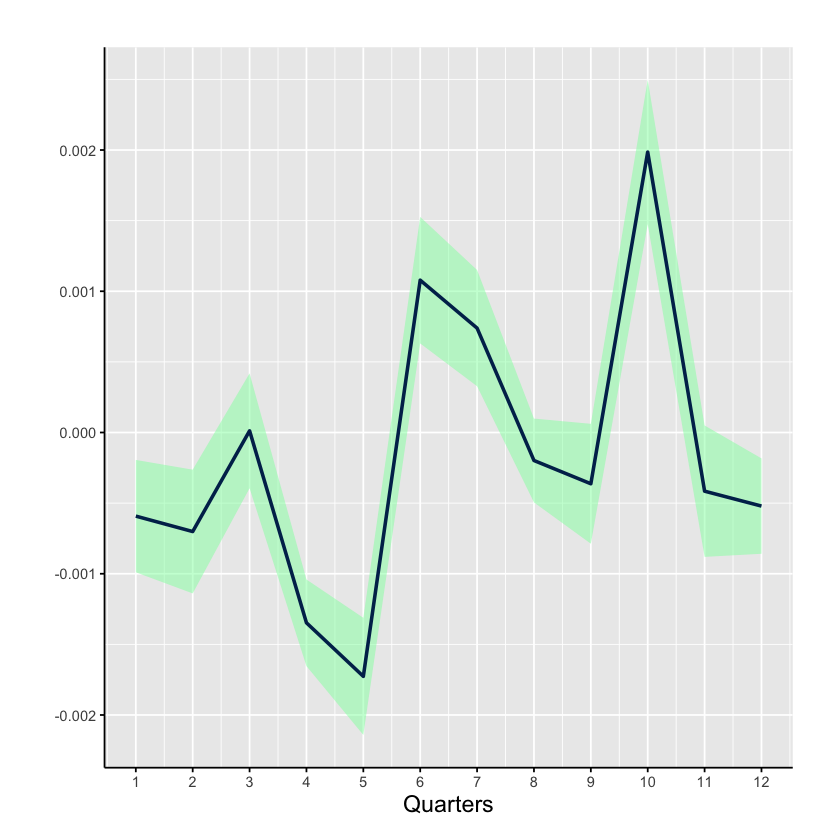

[1] "endog var"
[1] "ur_D1"
[1] "t2m_hd"


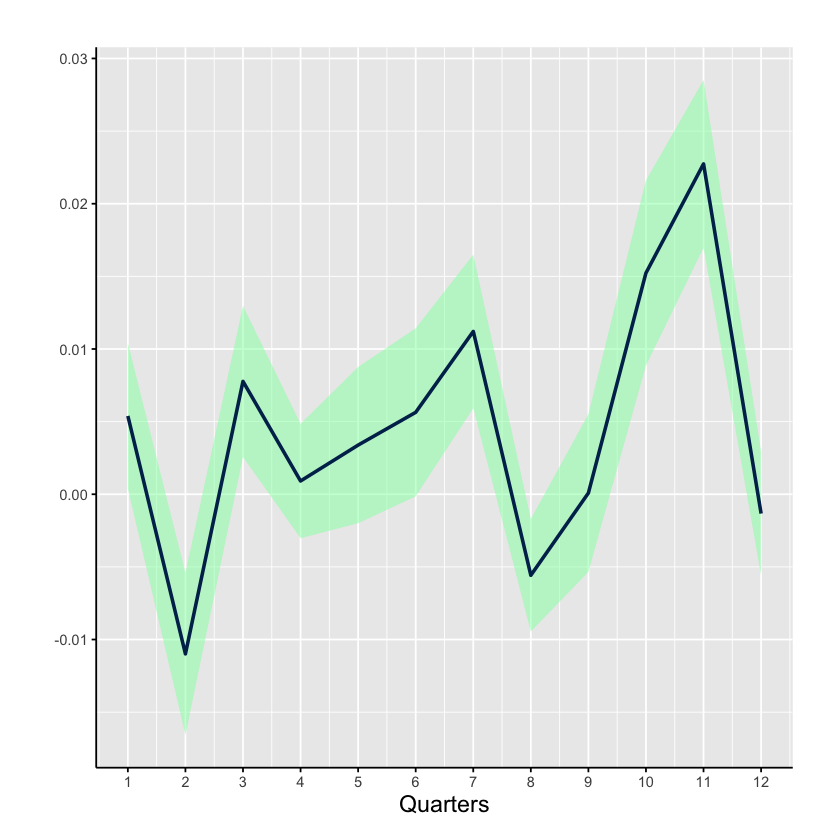

[1] "endog var"
[1] "ur_D1"
[1] "t2m_std_D1"


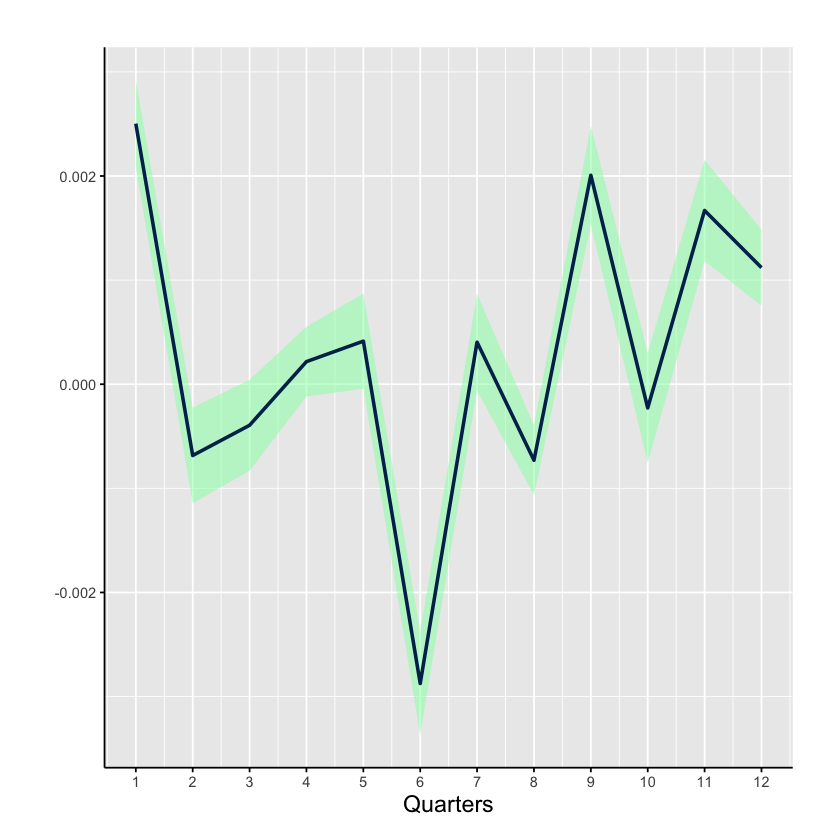

[1] "endog var"
[1] "ur_D1"
[1] "Medit_factor_tp"


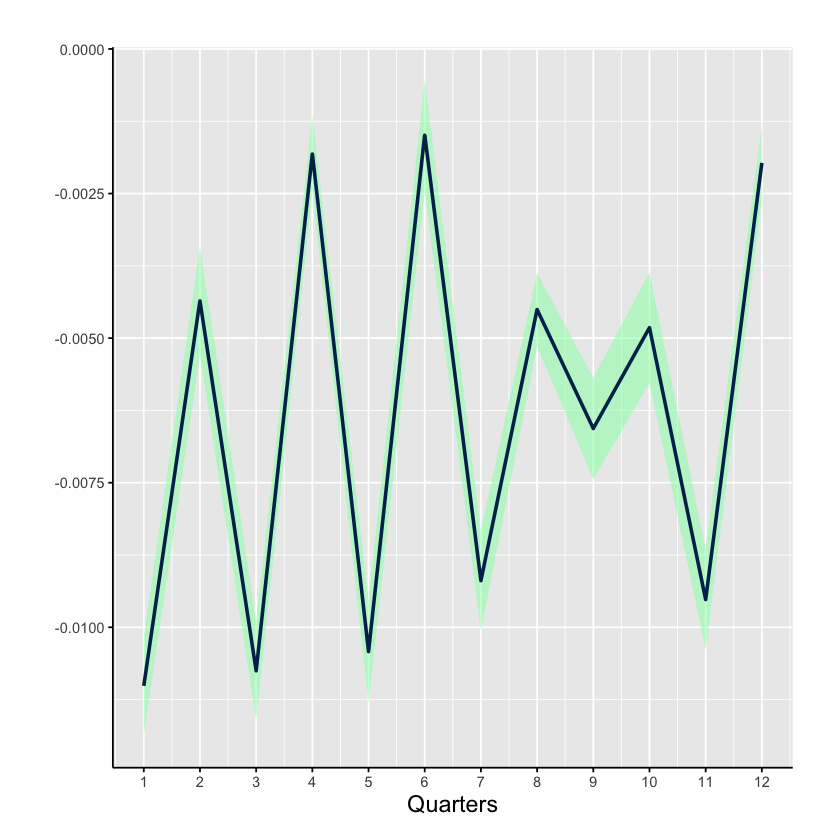

[1] "endog var"
[1] "ur_D1"
[1] "Medit_factor_t2m_D1"


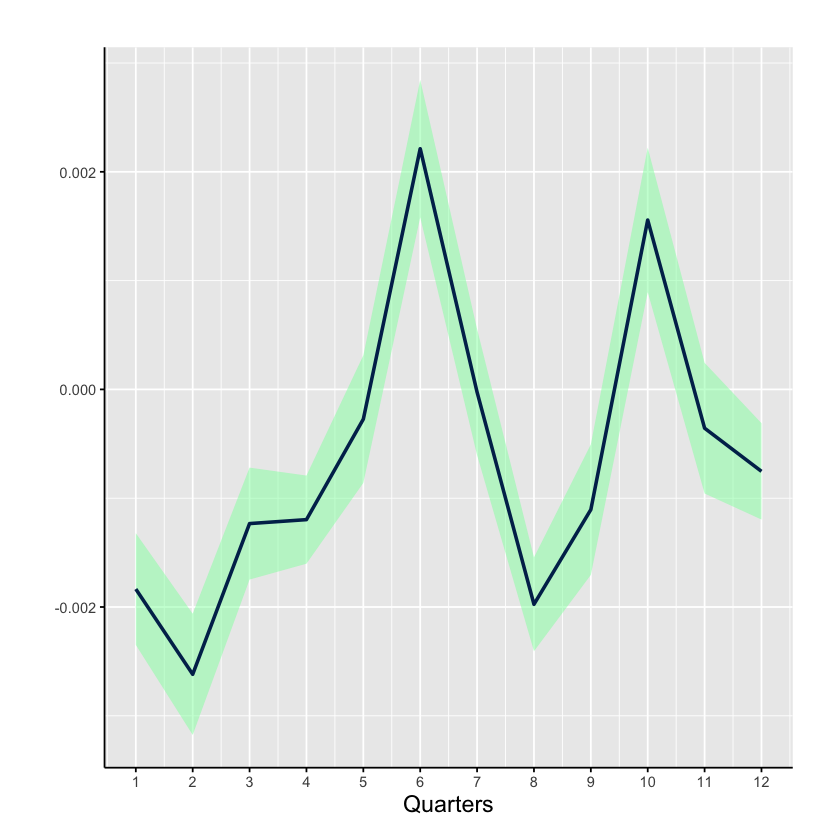

[1] "endog var"
[1] "hpi_log_D1"
[1] "fwi_D1"


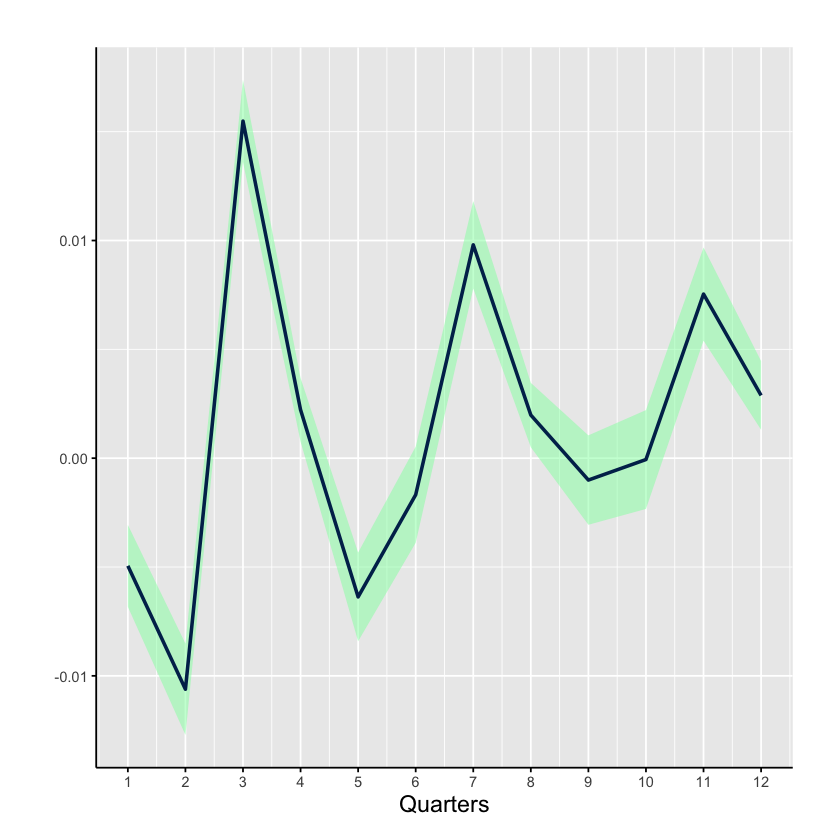

[1] "endog var"
[1] "hpi_log_D1"
[1] "high_fire_days"


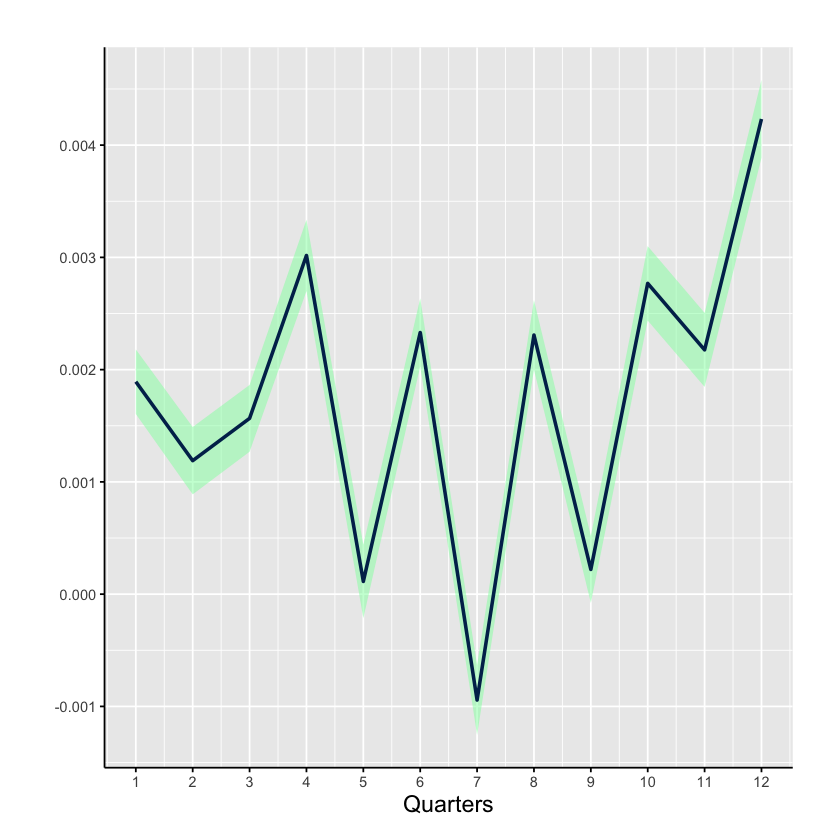

[1] "endog var"
[1] "hpi_log_D1"
[1] "tp_hd"


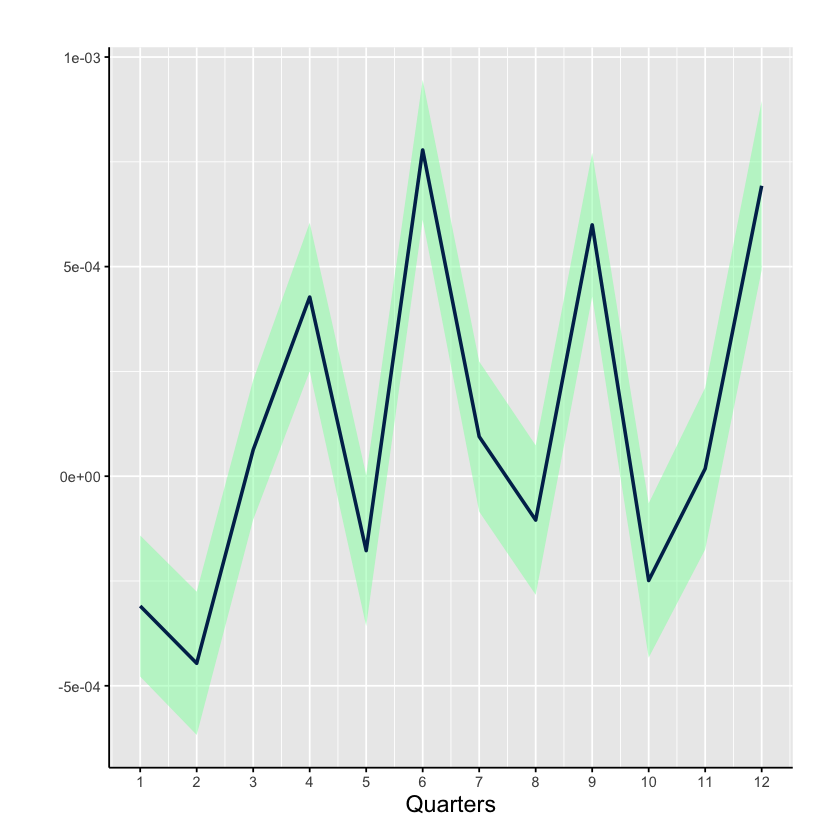

[1] "endog var"
[1] "hpi_log_D1"
[1] "tp_std_mm_hour_D1"


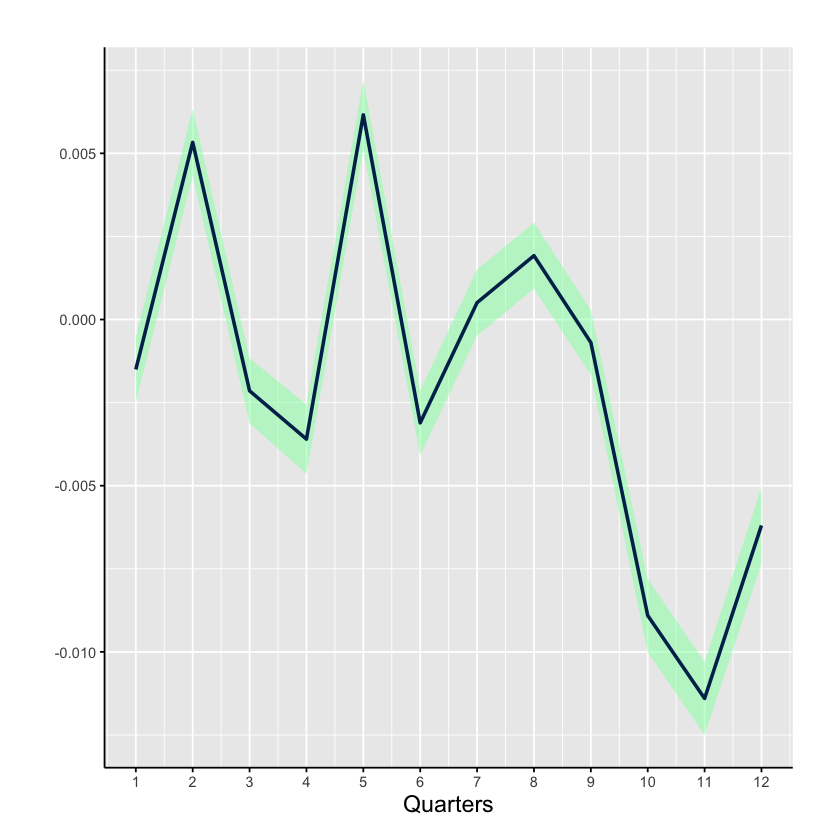

[1] "endog var"
[1] "hpi_log_D1"
[1] "t2m_hd"


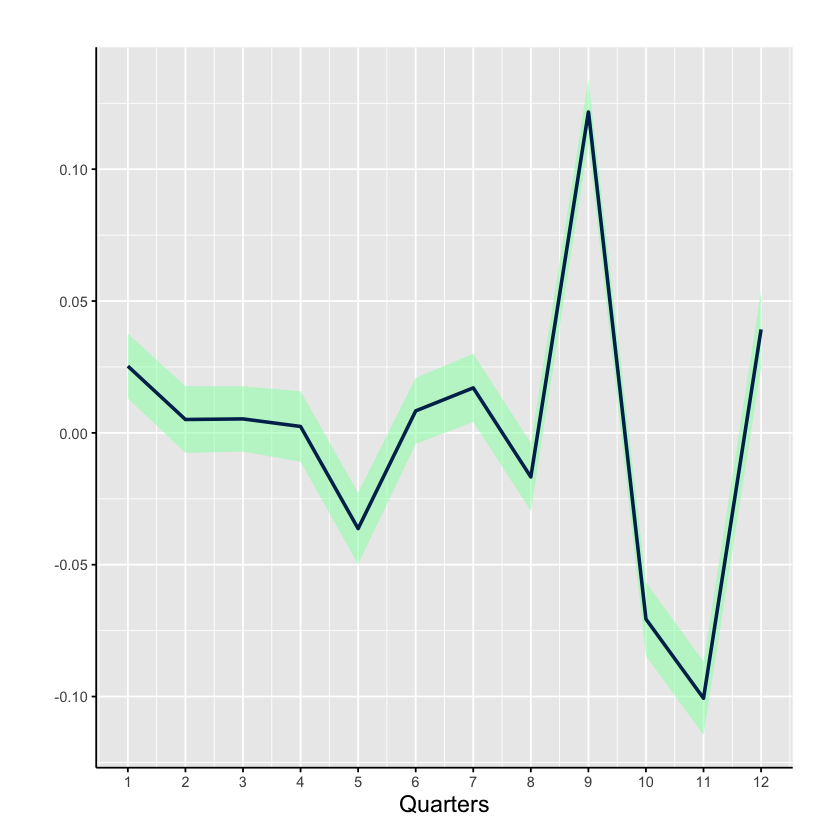

[1] "endog var"
[1] "hpi_log_D1"
[1] "t2m_std_D1"


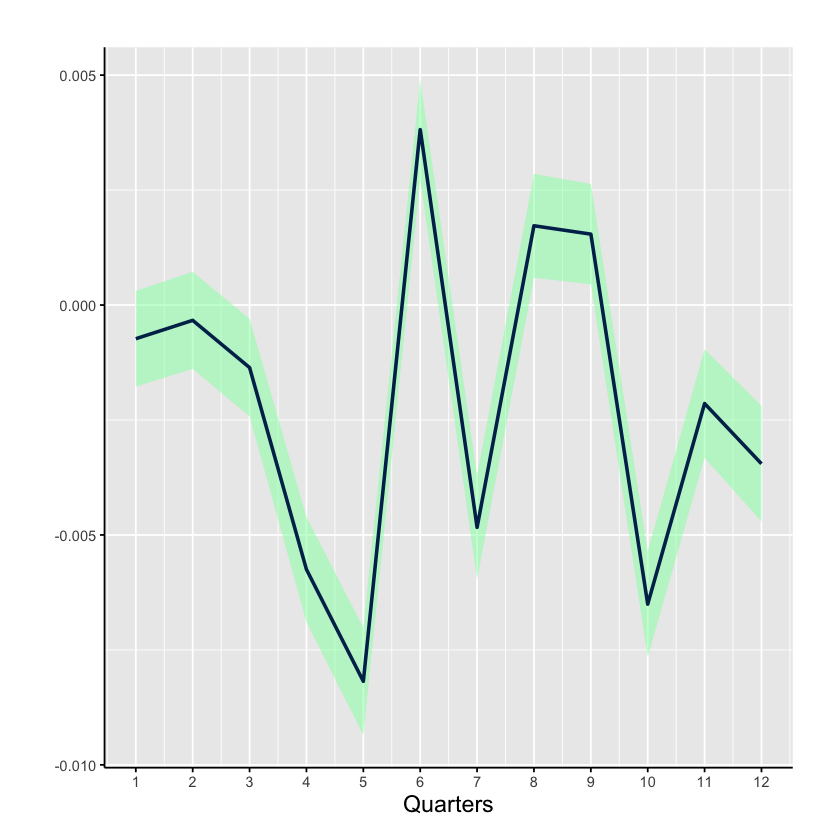

[1] "endog var"
[1] "hpi_log_D1"
[1] "Medit_factor_tp"


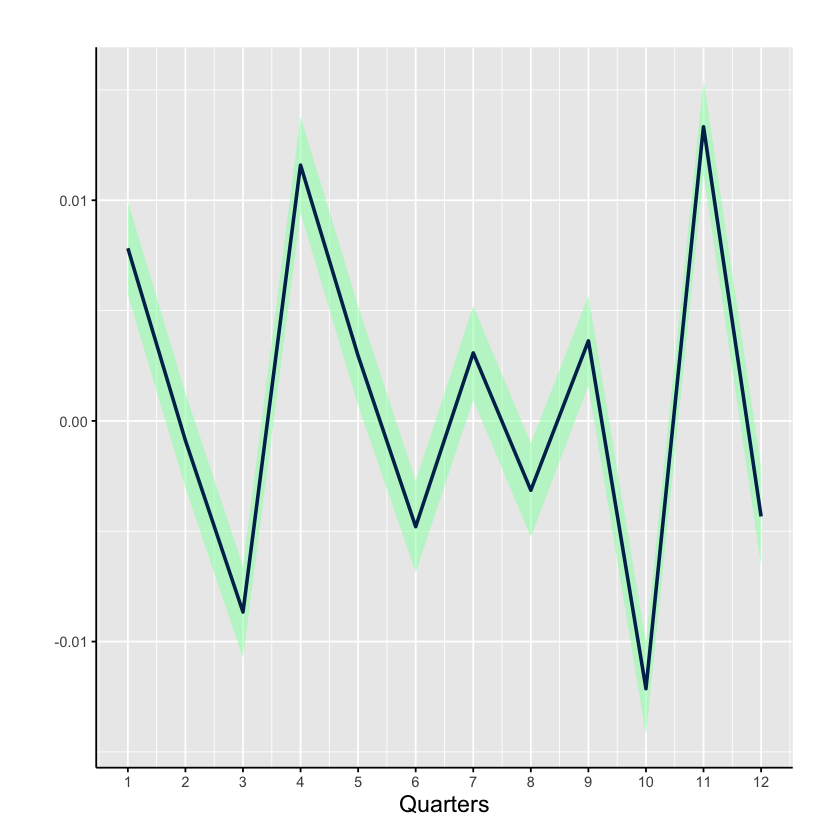

[1] "endog var"
[1] "hpi_log_D1"
[1] "Medit_factor_t2m_D1"


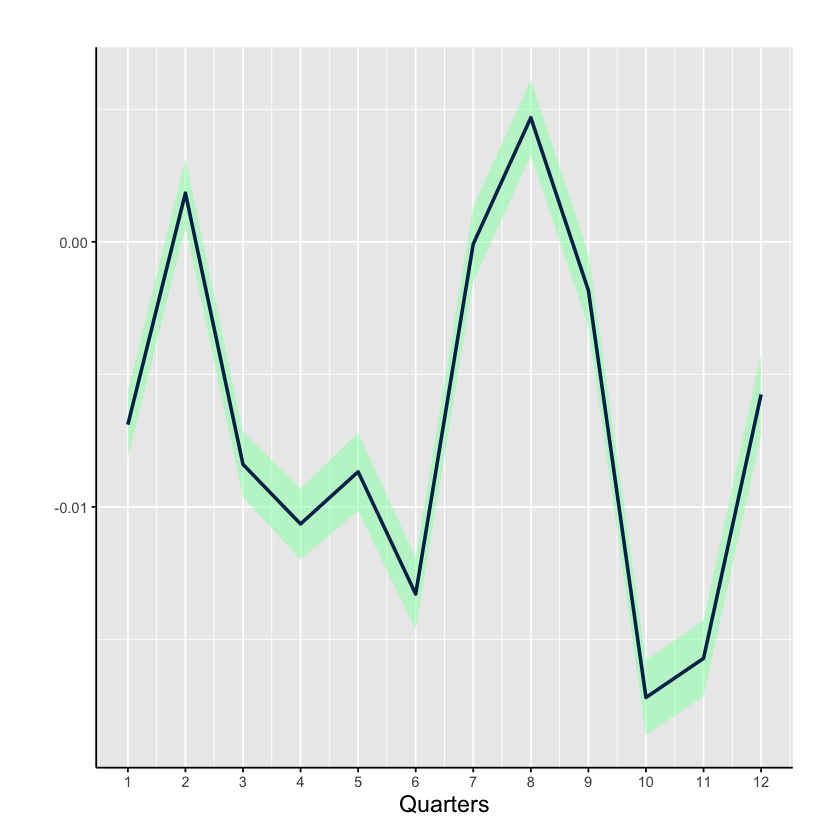

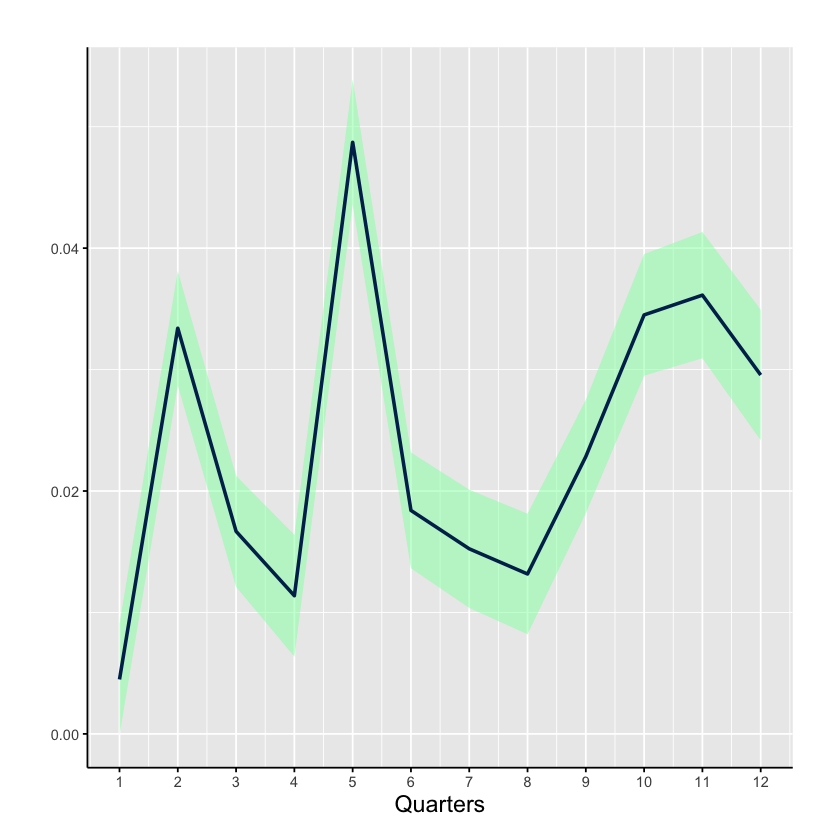

In [9]:
# shock <- c('t2m_wtd_std','tp_1000_wtd_std', 't2m_wtd_hd','tp_1000_wtd_hd','medit_factor_tp_weight'	,'medit_factor_t2m_weight' )
# l_exog_data <- c('t2m_wtd_hd', 'tp_1000_wtd_hd', 
#                 't2m_wtd_std','tp_1000_wtd_std', 'medit_factor_tp_weight'	,'medit_factor_t2m_weight')
endog        <- c("purchases_log_D1", "ur_D1", "hpi_log_D1")
shock     <- c(                       # contemporaneous exogenous terms
  "fwi_D1", "high_fire_days", "tp_hd",
  "tp_std_mm_hour_D1", "t2m_hd", "t2m_std_D1", "Medit_factor_tp",
"Medit_factor_t2m_D1"
)

c_exog_data <- c('Quadratic_Trend' , 'Linear_Trend')                
for (endog_var in endog) {
    for (shock_var in exo_base) {
    
    # Prepare c_exog_data: endog_data without the current endog_var
    c_exog_data_endog_removed <- setdiff(endog, endog_var)
    l_exog_data_removed <- setdiff(exo_base, shock_var)
    c_exog_complete <- c(c_exog_data_endog_removed, c_exog_data)

    # Calculate lp_lin_panel
    result <- lp_lin_panel(data_set = df_tmp_df, data_sample = 'Full',  
                            endog = endog_var, shock = shock_var, 
                            diff_shock=FALSE, cumul_mult = TRUE, 
                            panel_model = "within", panel_effect = "individual", iv_reg = FALSE, instrum = FALSE, use_gmm = FALSE, 
                            c_exog_data = c_exog_complete, 
                            l_exog_data = l_exog_data_removed, 
                              lags_exog_data = 2, confint = 1.67, hor = 12)

    plot_irf <- plot_irf_lp(lp_output = result,shock_var = shock_var, endog_var = endog_var)

    print(plot_irf)
        print("endog var")
    print(endog_var)
    print(shock_var)
    ggsave(filename = glue('lp_{endog_var}_{shock_var}.png'), plot = plot_irf, dpi = 300, width = 1500, height = 1500,units = c('px') ,path = '/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/climate-econometrics/countries/portugal/purchases_paper/outputs/data_plots/lps', device = 'png')

    }
}


## Shocks in Count

In [17]:
endog        <- c("purchases_log_D1", "ur_D1", "hpi_log_D1")
exo_base     <- c('fwi_D1', 'high_fire_days', 'cdd', 'extreme_precipitation_mm',
       'frequency_of_extreme_precipitation','num_heatwaves',
       'hot_days', 'num_tropical_nights', 'frost_days',  "Medit_factor_tp",
"Medit_factor_t2m_D1")
## ---------------- 3. prepare the master data frame -------------------------
df_panel <- quart_df %>% 
  arrange(CCA_2, time)
df_tmp <-  df_panel  %>% 
  mutate(time = yearquarter(time)) %>%  select(CCA_2, time, all_of(endog), all_of(exo_base)) 

# Step 1: Create linear trends that are specific to each municipality
df_tmp <- df_tmp %>%
  group_by(CCA_2) %>%
  mutate(Linear_Trend = row_number())  # Creates a linear trend for each municipality

# Step 2: Create quadratic trends that are specific to each municipality
df_tmp <- df_tmp %>%
  mutate(Quadratic_Trend = Linear_Trend^2)  # Quadratic trend is square of linear trend

                                  # no missing values
df_tmp_df <- as.data.frame(df_tmp)


[1] "endog var"
[1] "purchases_log_D1"
[1] "fwi_D1"


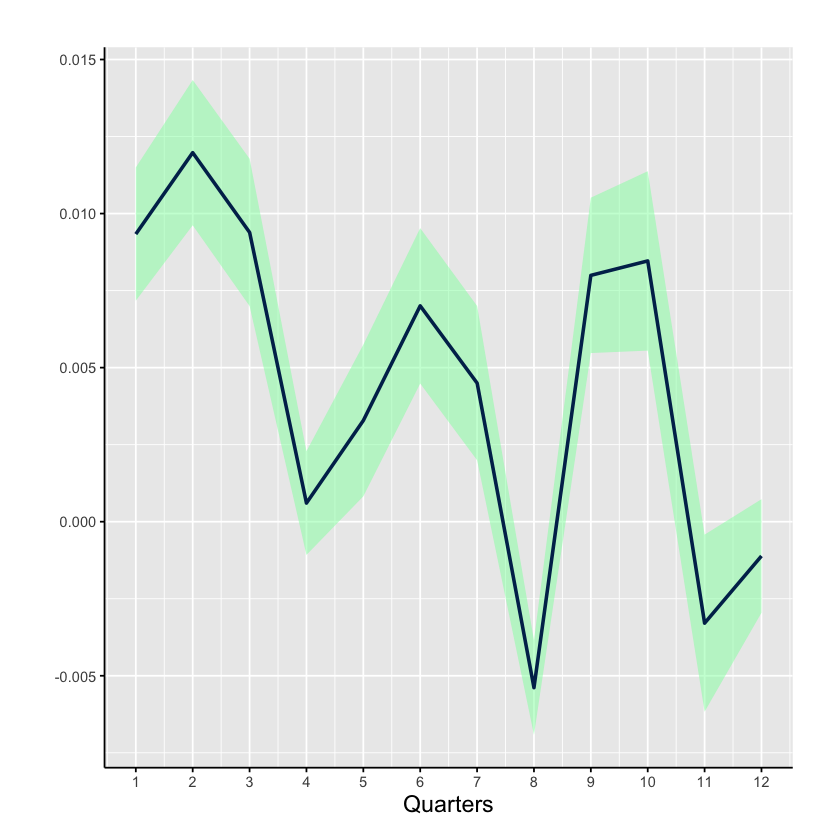

[1] "endog var"
[1] "purchases_log_D1"
[1] "high_fire_days"


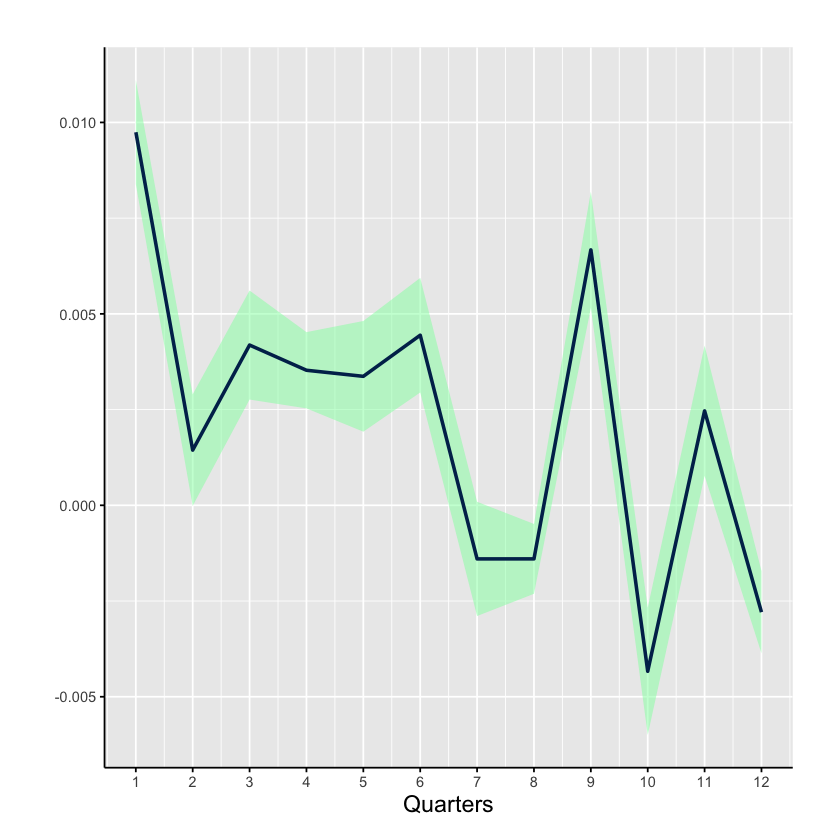

[1] "endog var"
[1] "purchases_log_D1"
[1] "cdd"


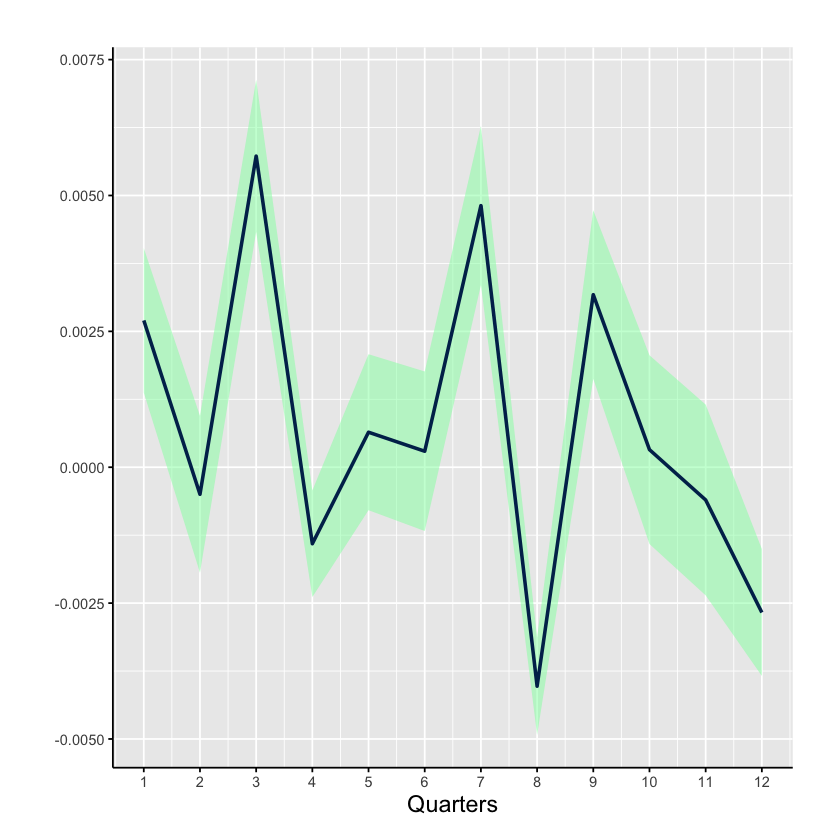

[1] "endog var"
[1] "purchases_log_D1"
[1] "extreme_precipitation_mm"


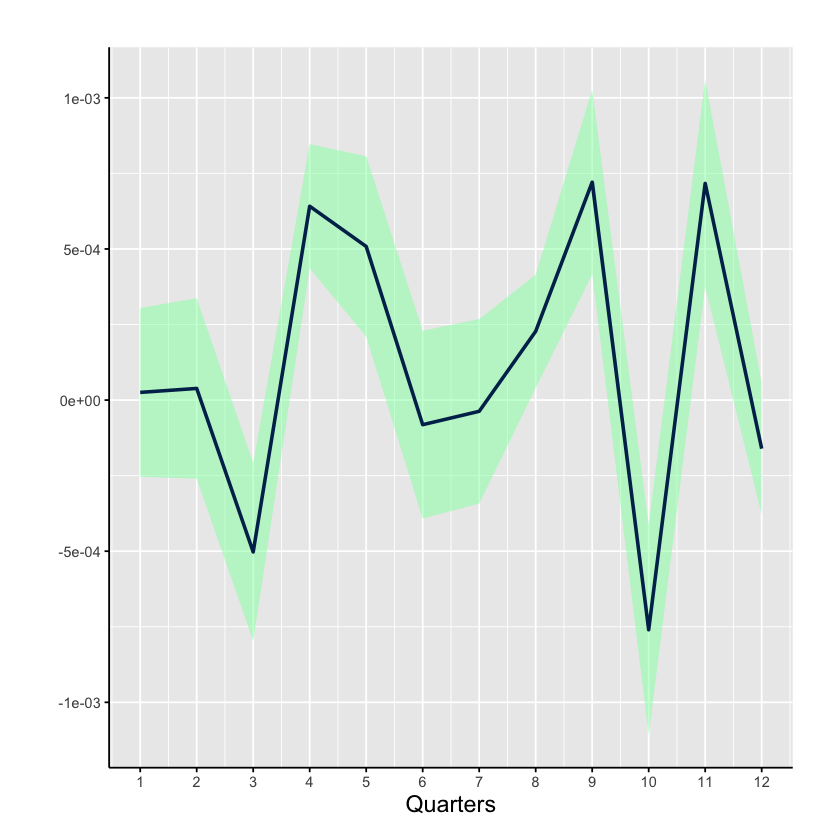

[1] "endog var"
[1] "purchases_log_D1"
[1] "frequency_of_extreme_precipitation"


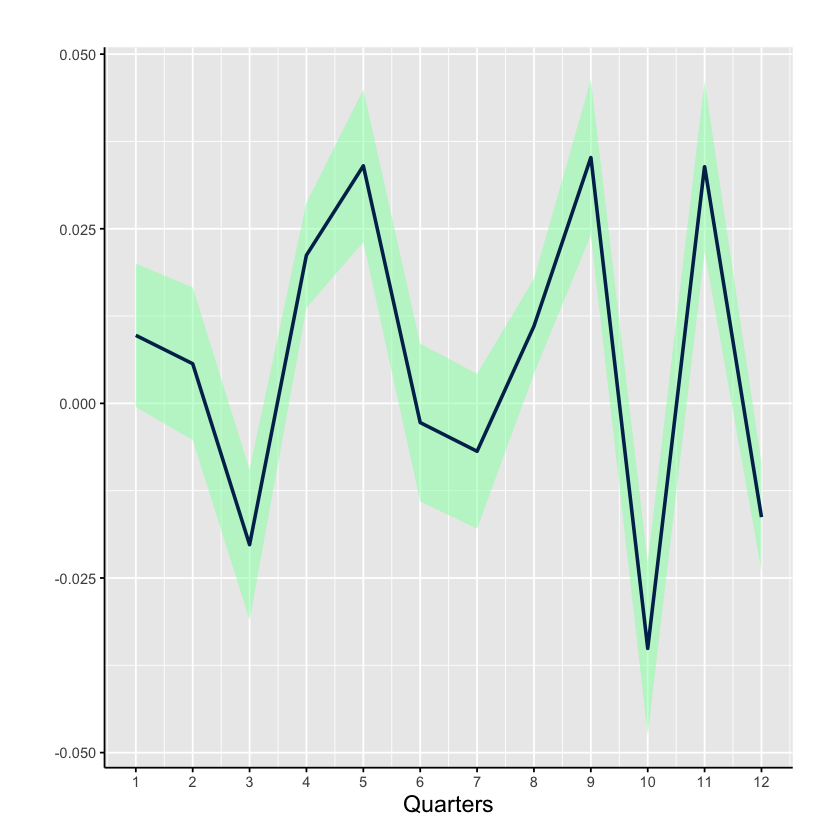

[1] "endog var"
[1] "purchases_log_D1"
[1] "num_heatwaves"


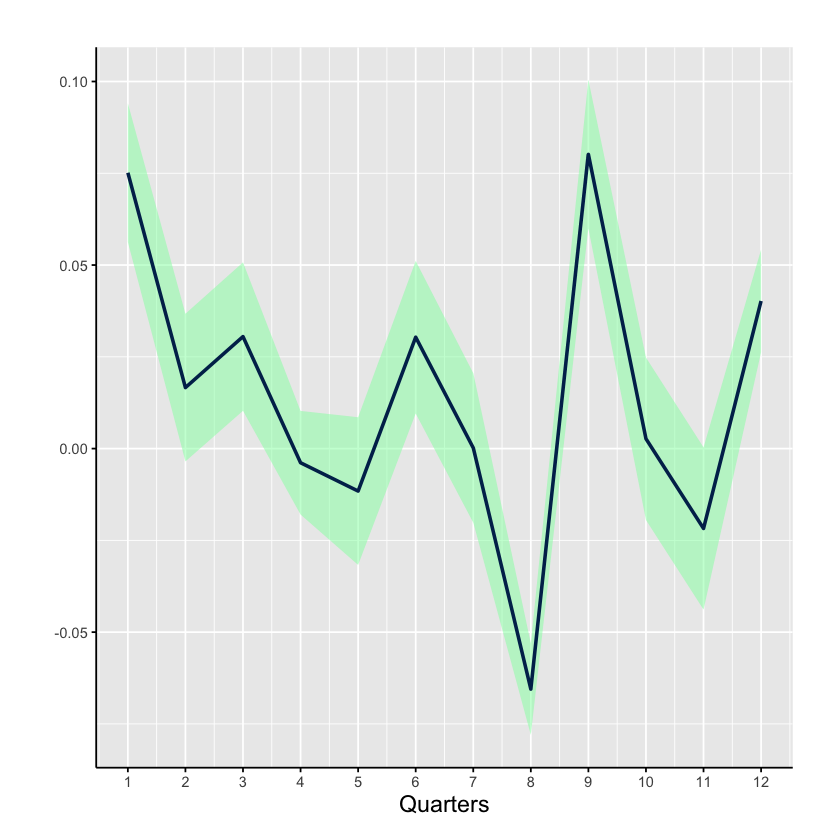

[1] "endog var"
[1] "purchases_log_D1"
[1] "hot_days"


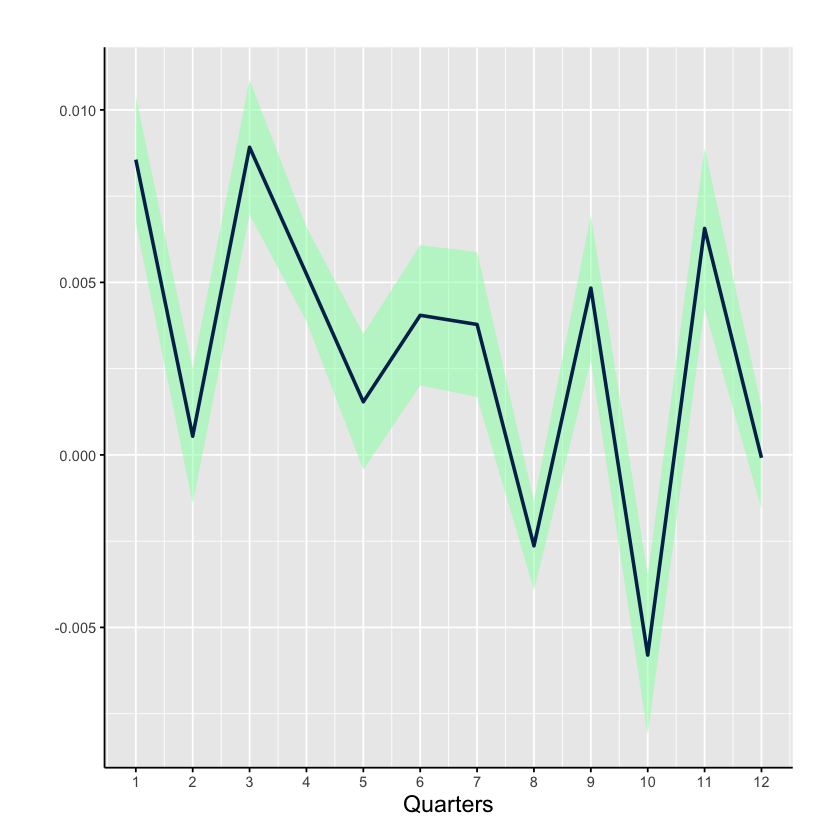

[1] "endog var"
[1] "purchases_log_D1"
[1] "num_tropical_nights"


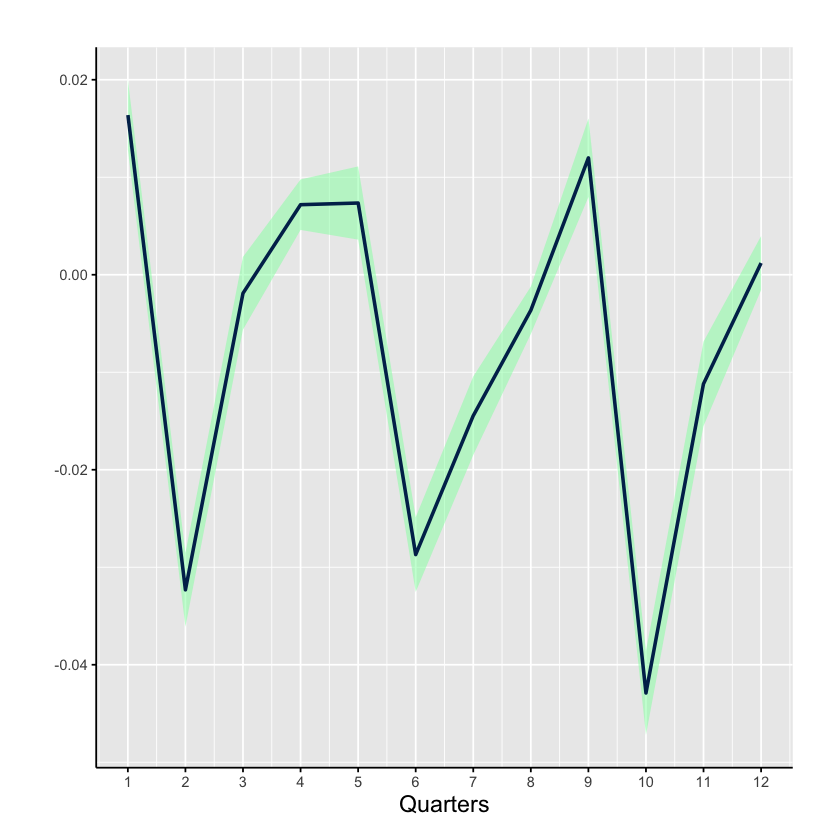

[1] "endog var"
[1] "purchases_log_D1"
[1] "frost_days"


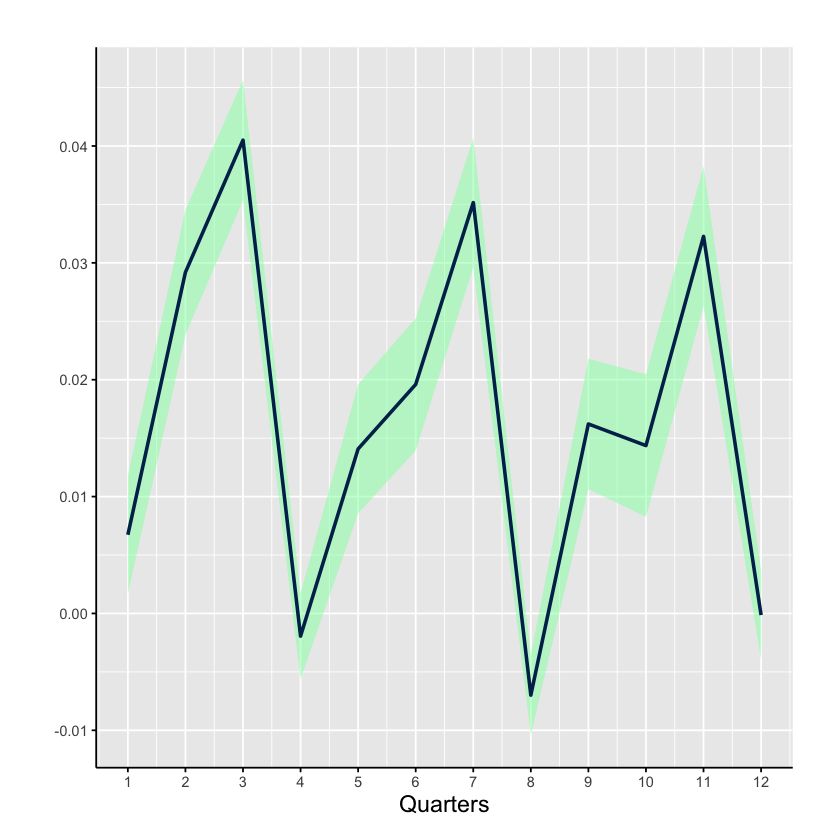

[1] "endog var"
[1] "purchases_log_D1"
[1] "Medit_factor_tp"


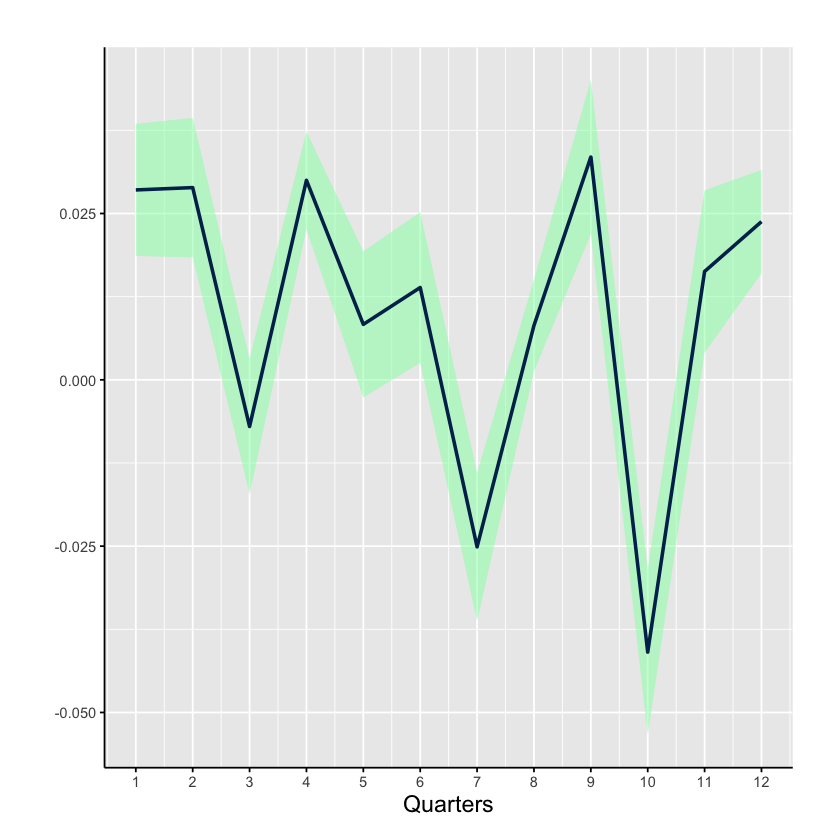

[1] "endog var"
[1] "purchases_log_D1"
[1] "Medit_factor_t2m_D1"


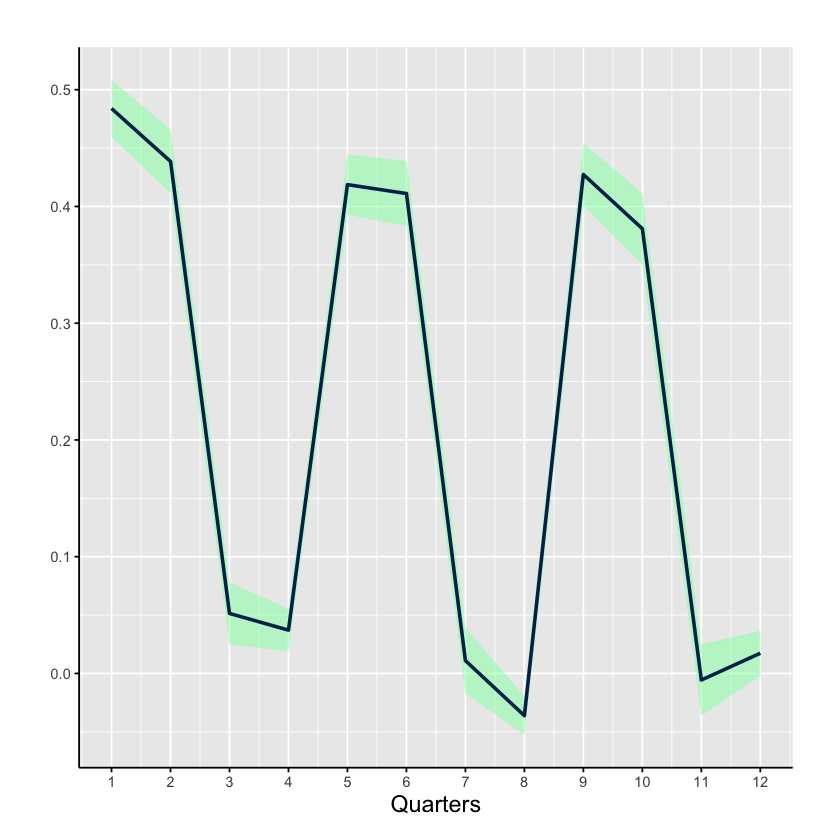

[1] "endog var"
[1] "ur_D1"
[1] "fwi_D1"


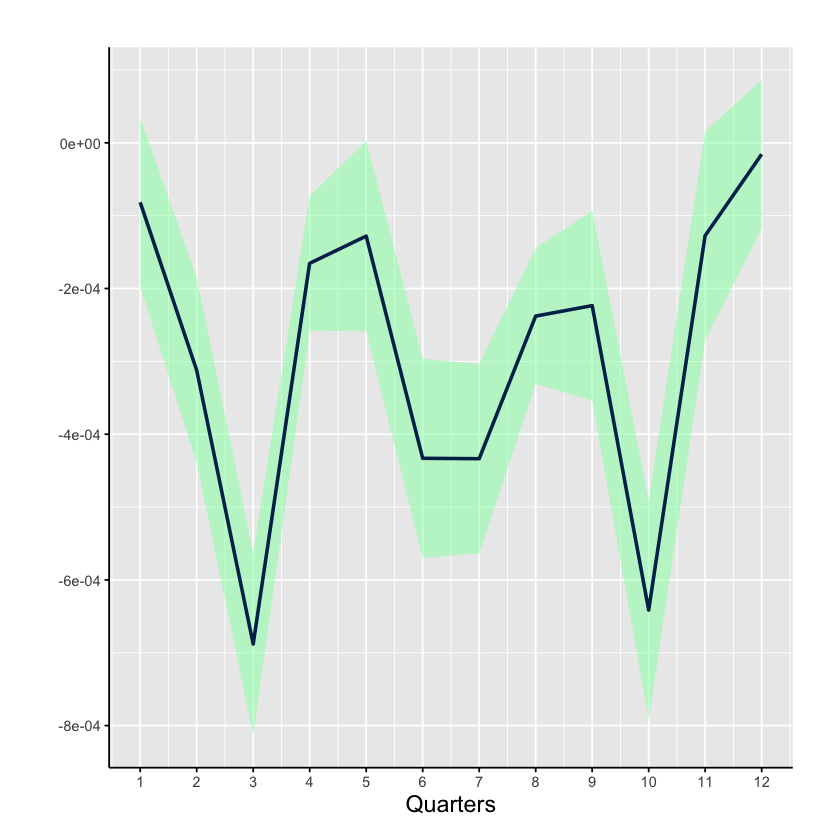

[1] "endog var"
[1] "ur_D1"
[1] "high_fire_days"


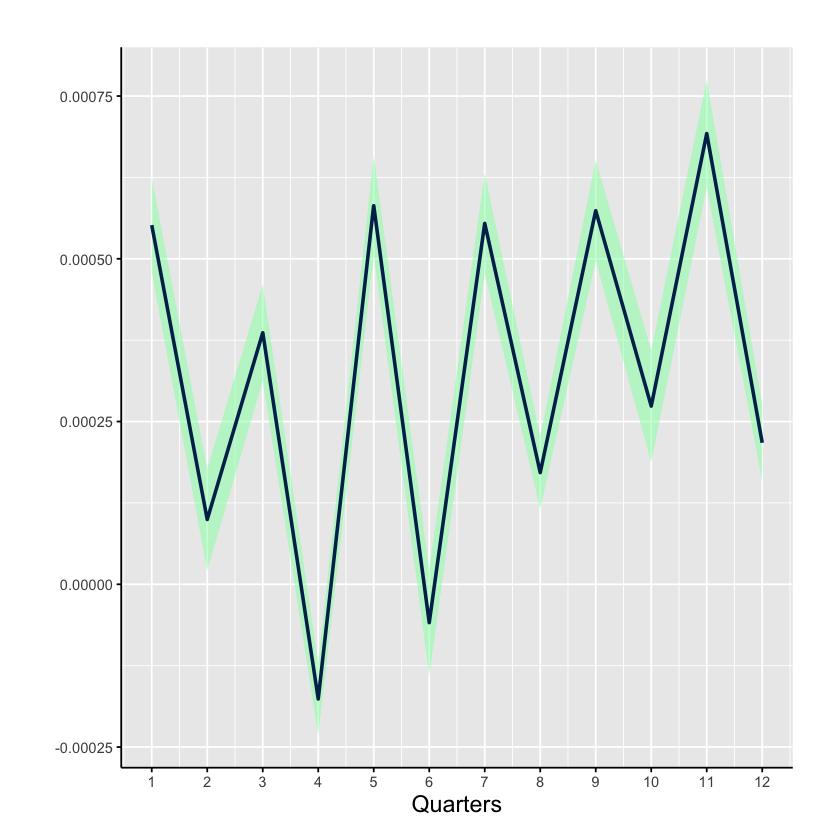

[1] "endog var"
[1] "ur_D1"
[1] "cdd"


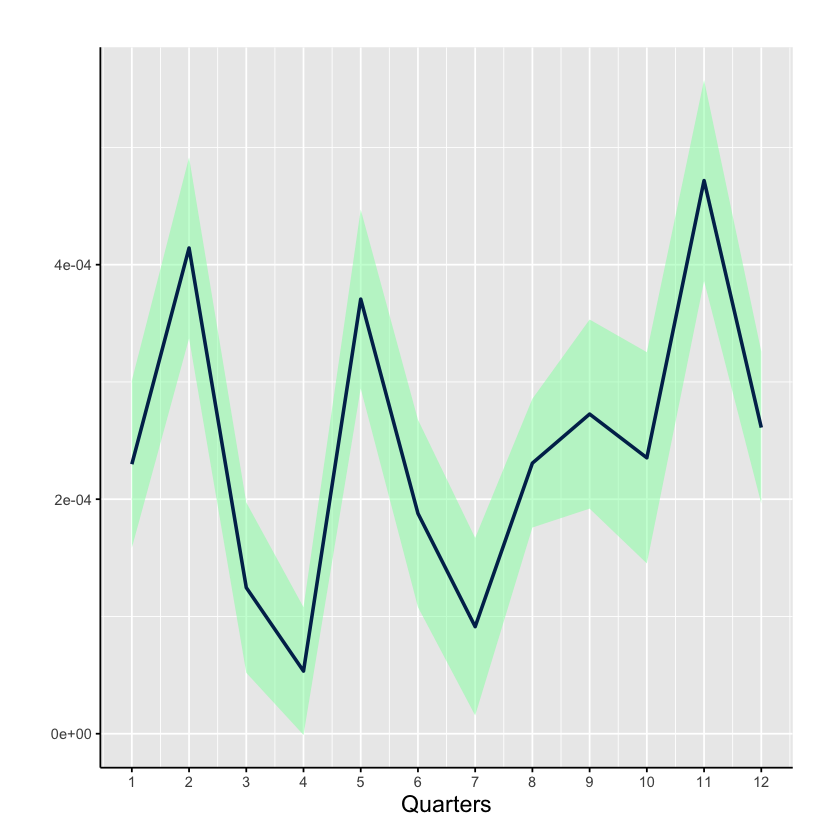

[1] "endog var"
[1] "ur_D1"
[1] "extreme_precipitation_mm"


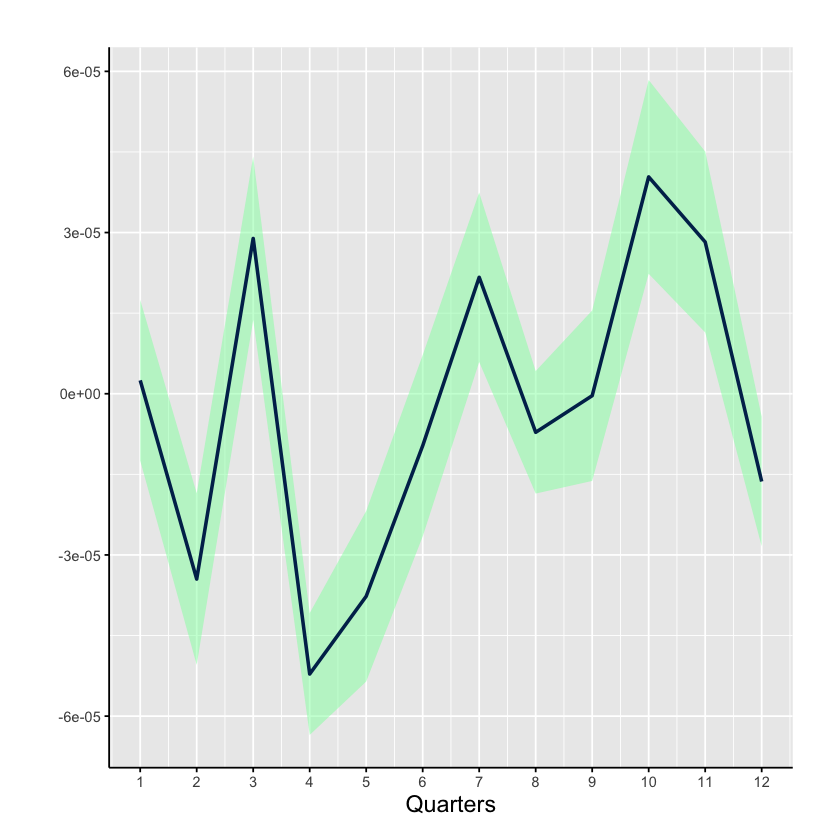

[1] "endog var"
[1] "ur_D1"
[1] "frequency_of_extreme_precipitation"


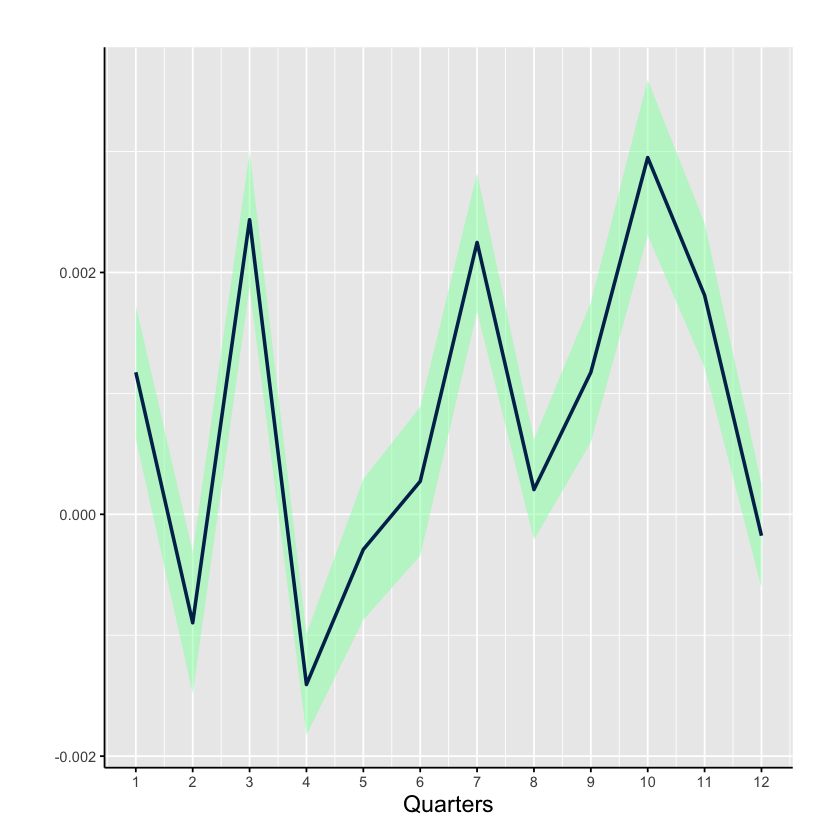

[1] "endog var"
[1] "ur_D1"
[1] "num_heatwaves"


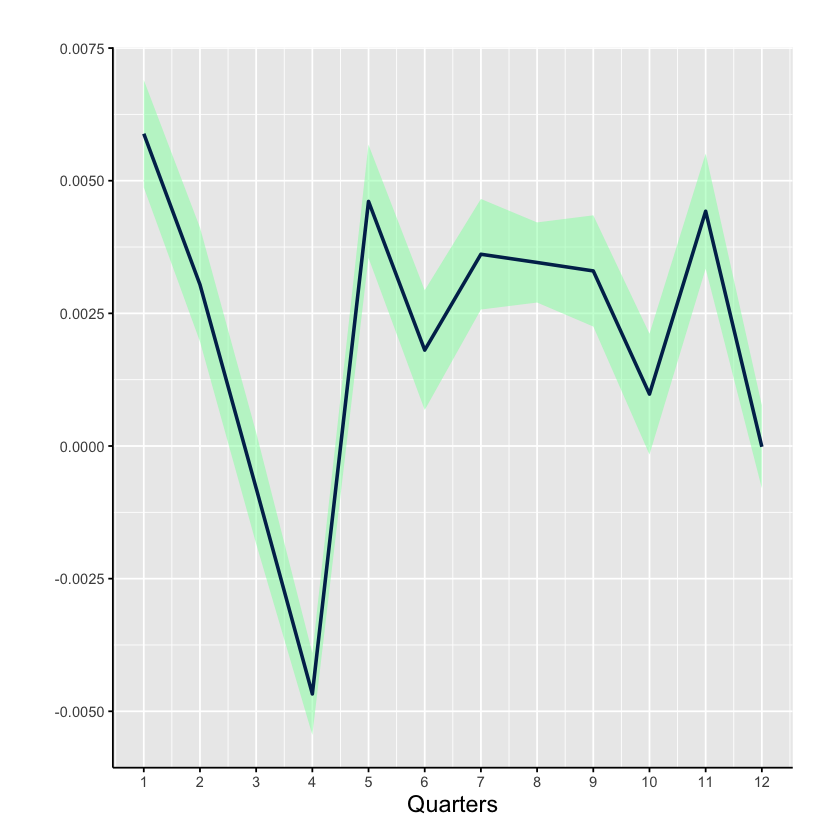

[1] "endog var"
[1] "ur_D1"
[1] "hot_days"


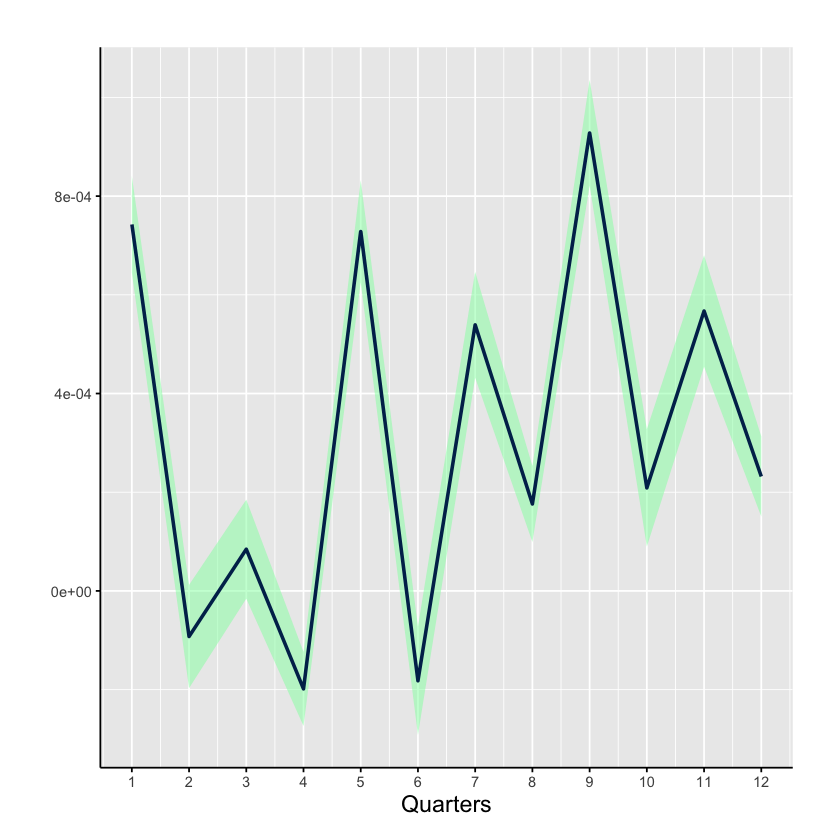

[1] "endog var"
[1] "ur_D1"
[1] "num_tropical_nights"


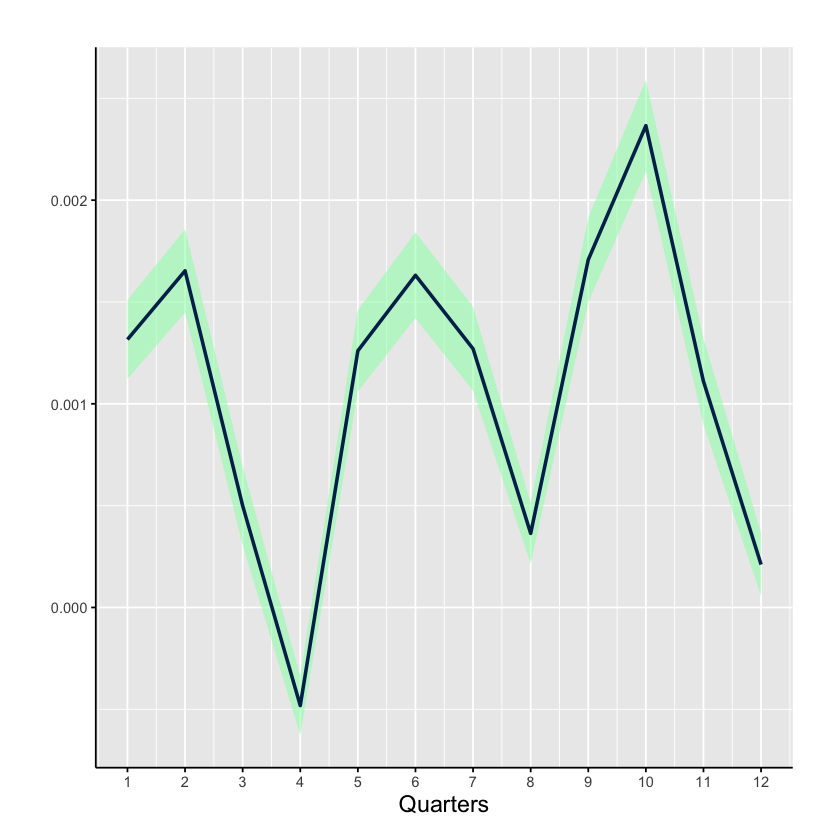

[1] "endog var"
[1] "ur_D1"
[1] "frost_days"


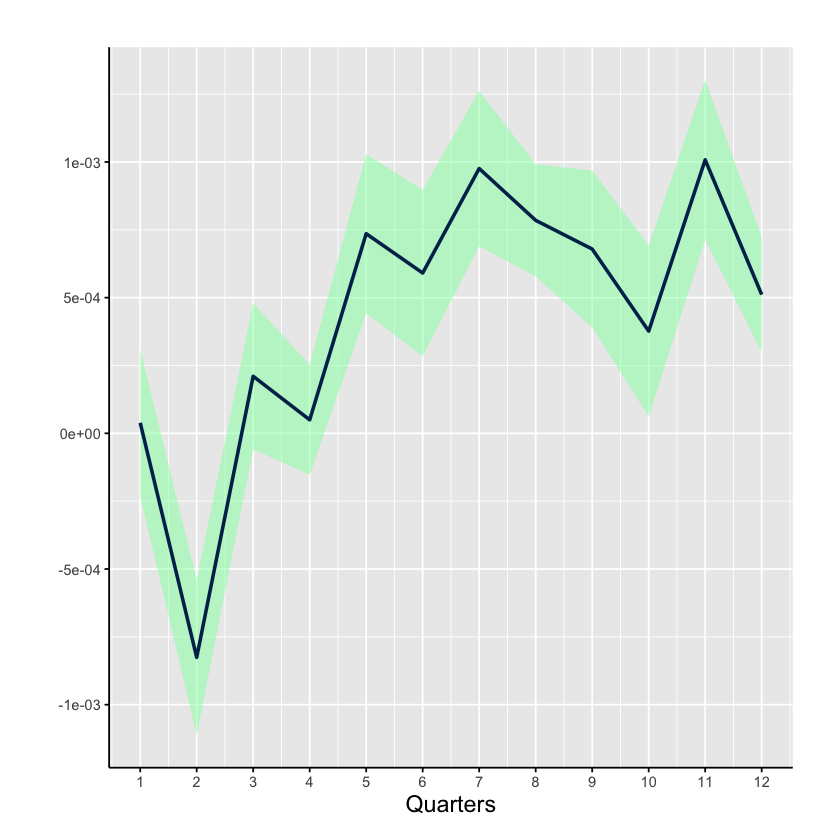

[1] "endog var"
[1] "ur_D1"
[1] "Medit_factor_tp"


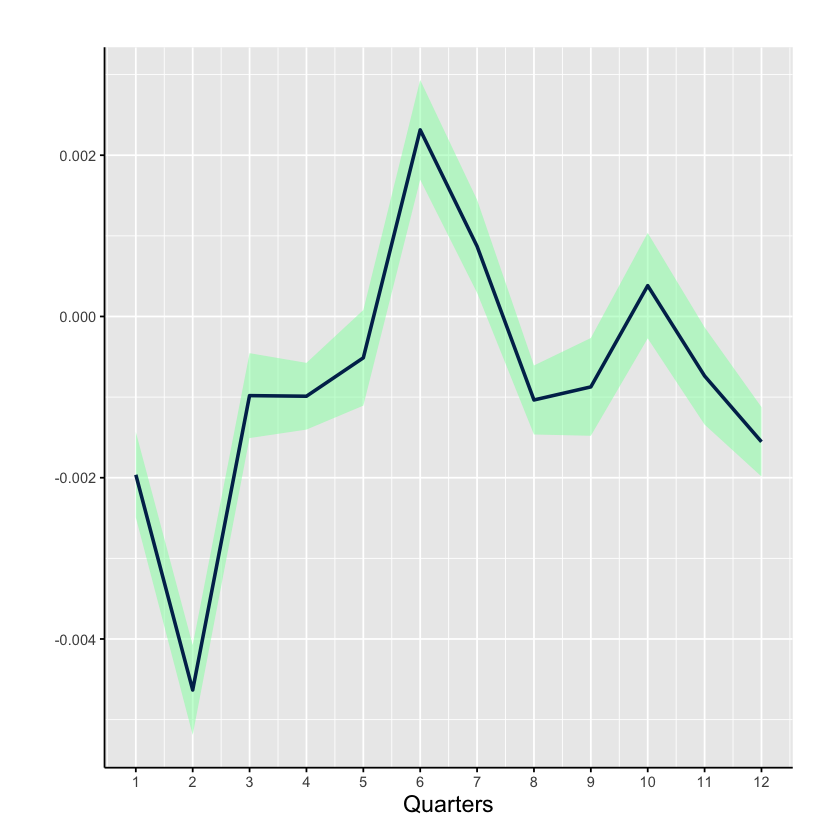

[1] "endog var"
[1] "ur_D1"
[1] "Medit_factor_t2m_D1"


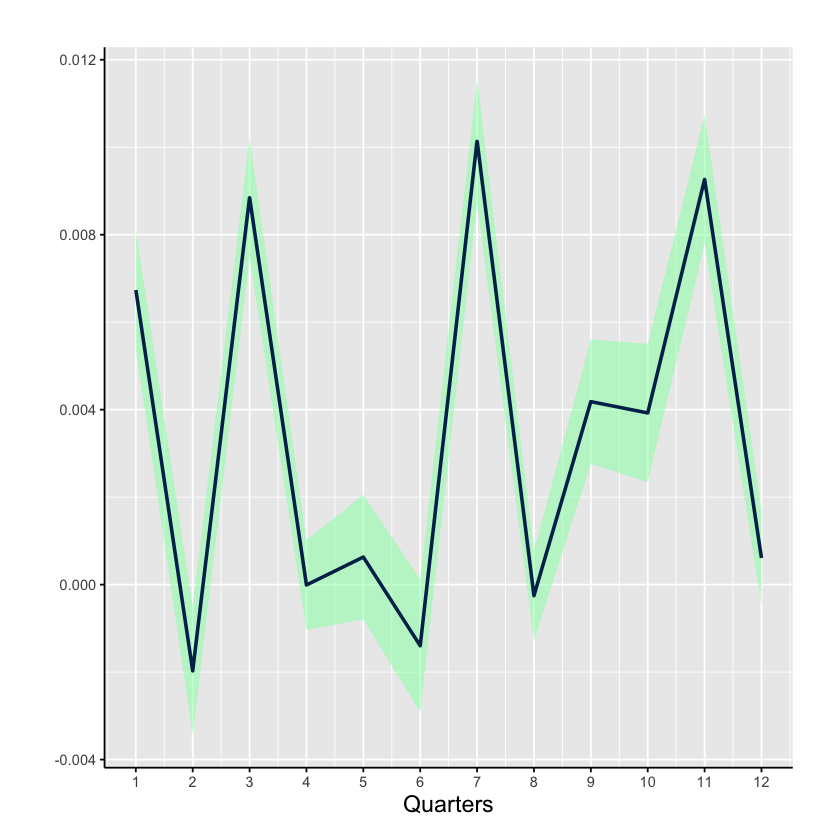

[1] "endog var"
[1] "hpi_log_D1"
[1] "fwi_D1"


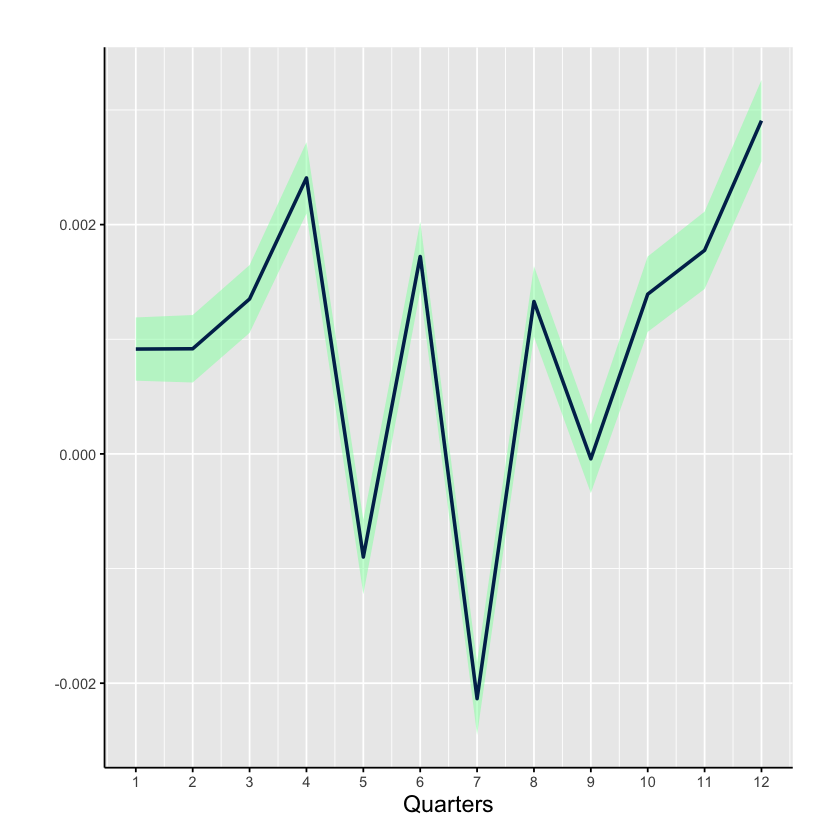

[1] "endog var"
[1] "hpi_log_D1"
[1] "high_fire_days"


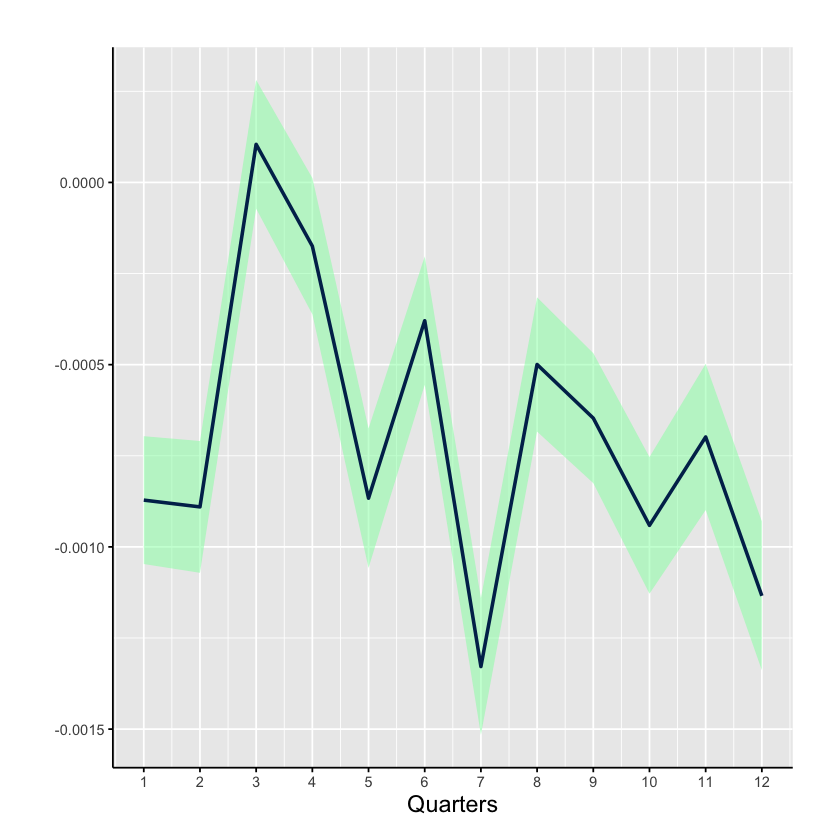

[1] "endog var"
[1] "hpi_log_D1"
[1] "cdd"


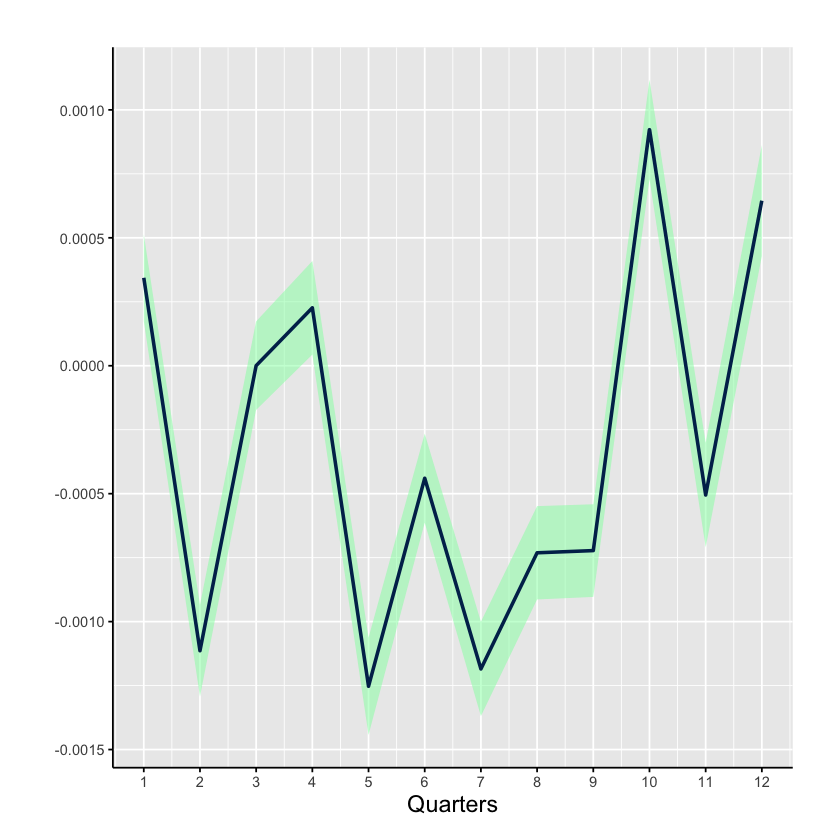

[1] "endog var"
[1] "hpi_log_D1"
[1] "extreme_precipitation_mm"


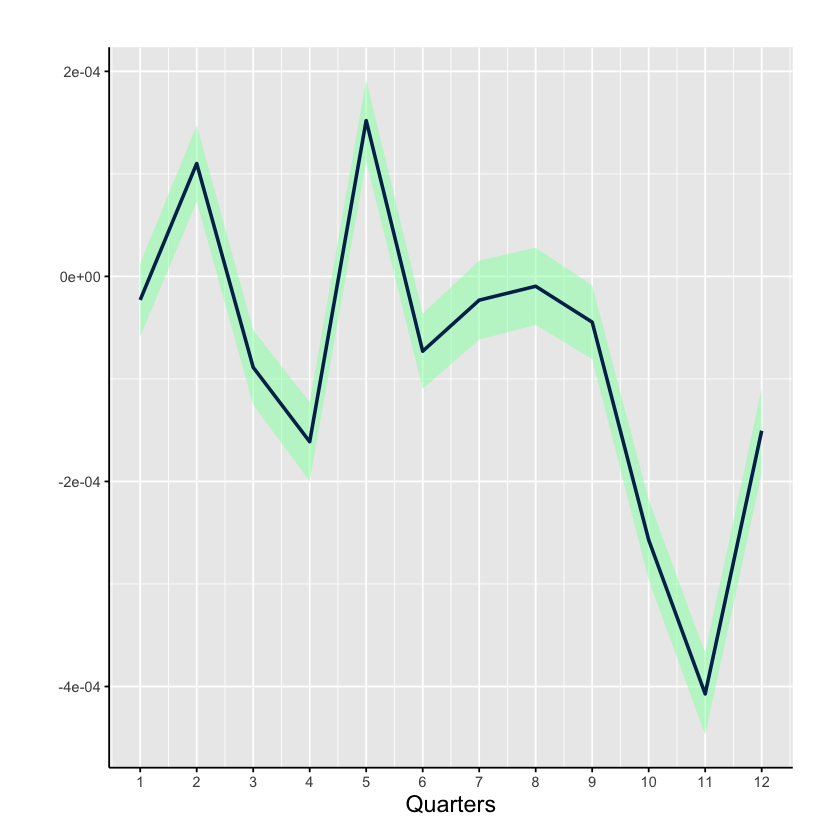

[1] "endog var"
[1] "hpi_log_D1"
[1] "frequency_of_extreme_precipitation"


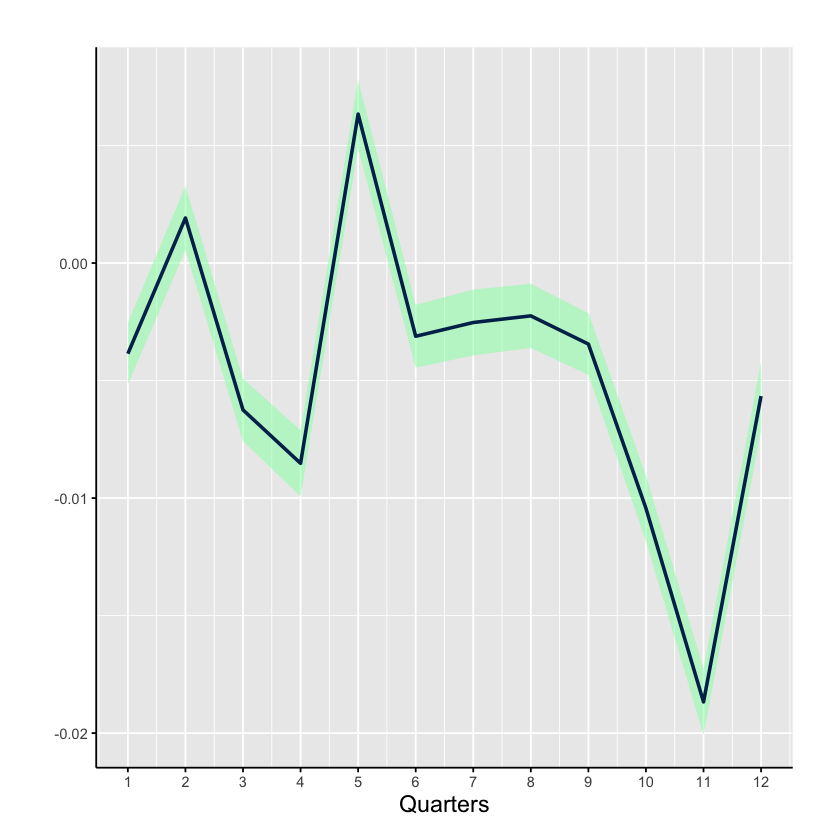

[1] "endog var"
[1] "hpi_log_D1"
[1] "num_heatwaves"


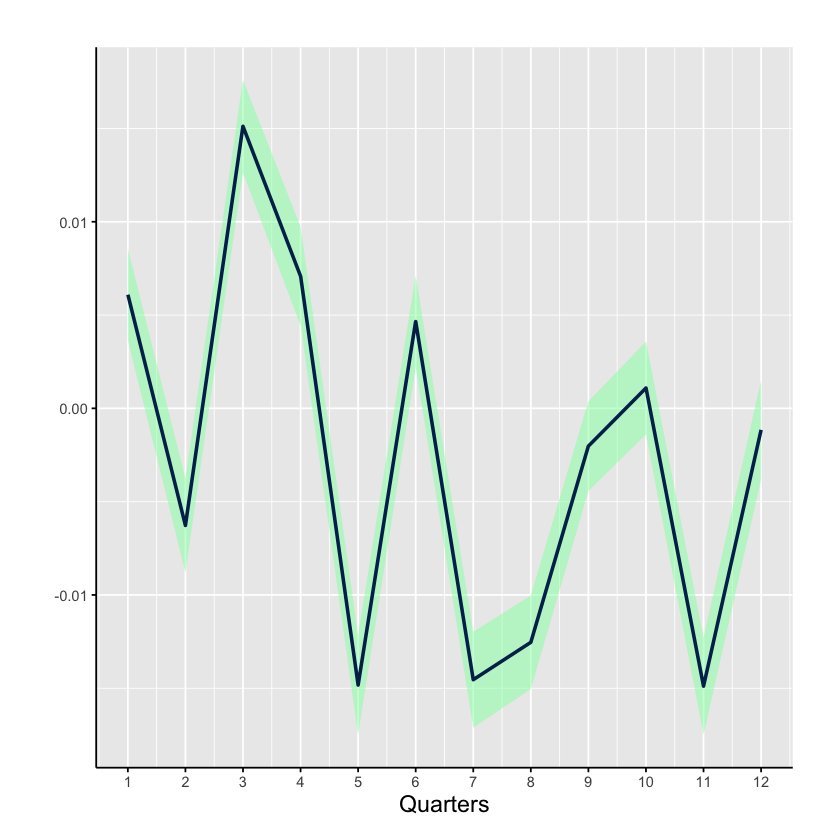

[1] "endog var"
[1] "hpi_log_D1"
[1] "hot_days"


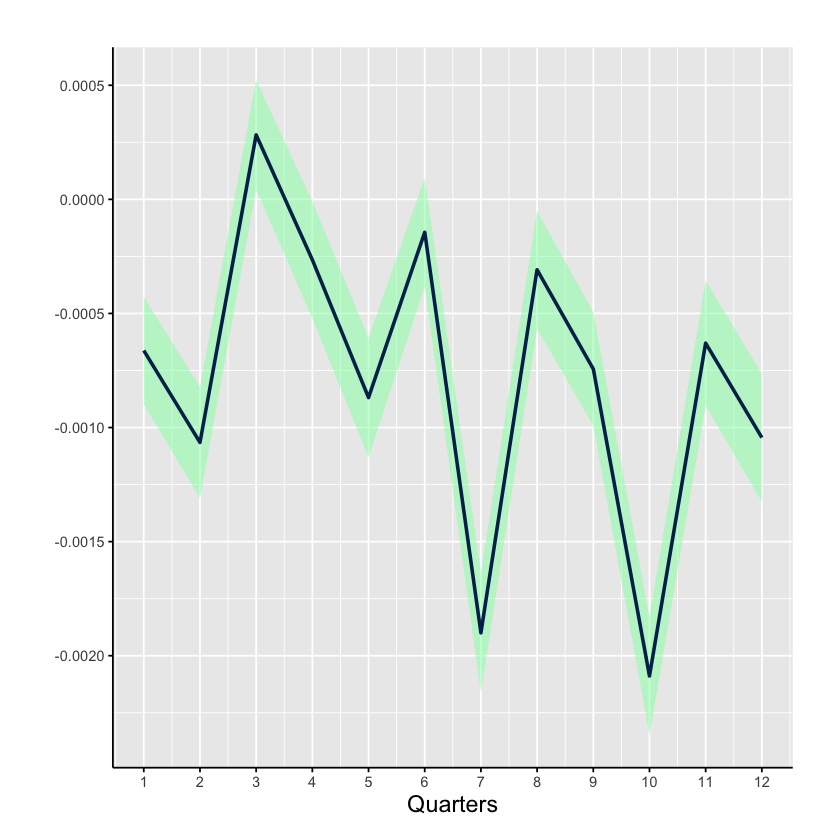

[1] "endog var"
[1] "hpi_log_D1"
[1] "num_tropical_nights"


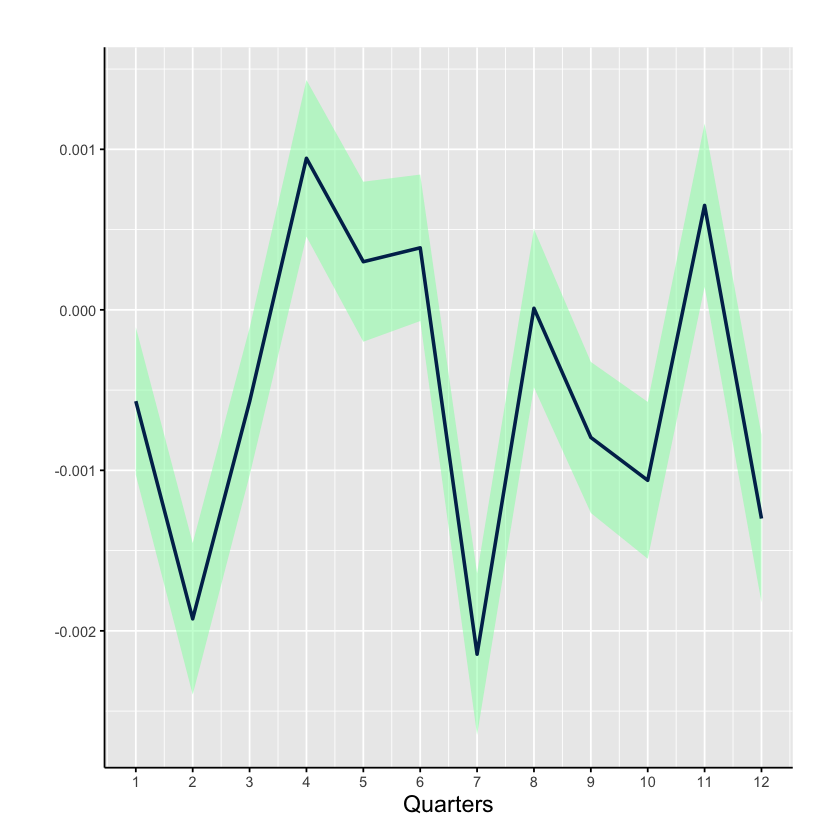

[1] "endog var"
[1] "hpi_log_D1"
[1] "frost_days"


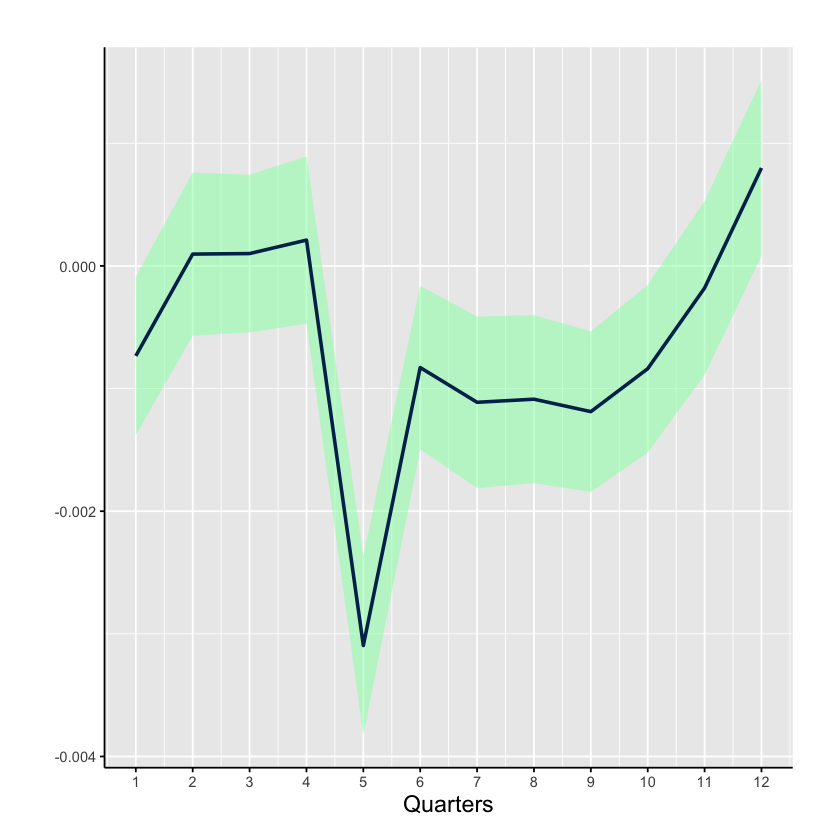

[1] "endog var"
[1] "hpi_log_D1"
[1] "Medit_factor_tp"


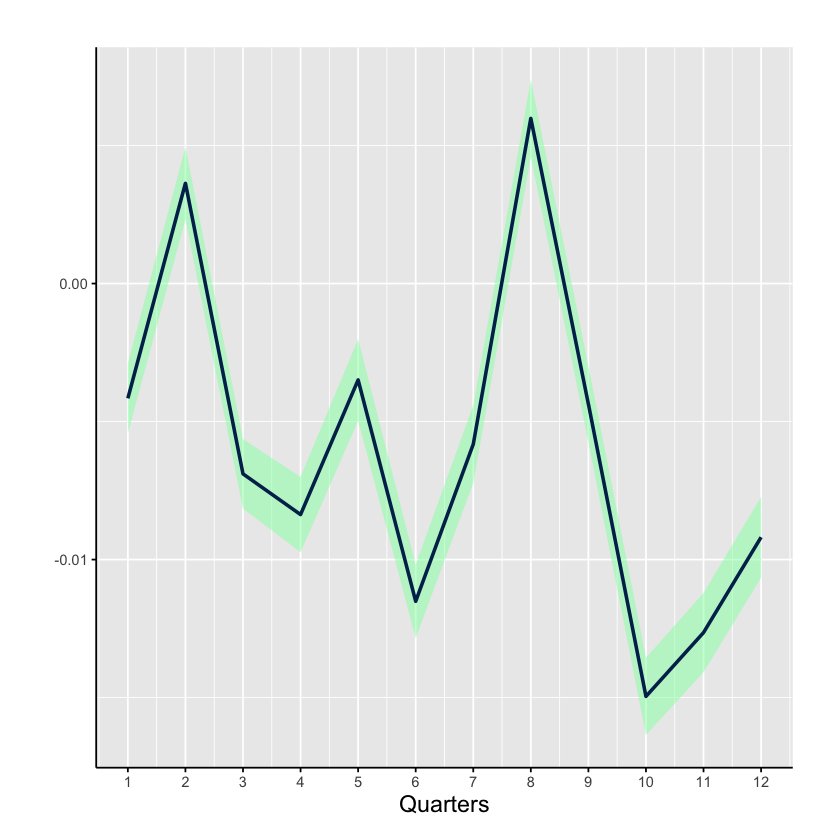

[1] "endog var"
[1] "hpi_log_D1"
[1] "Medit_factor_t2m_D1"


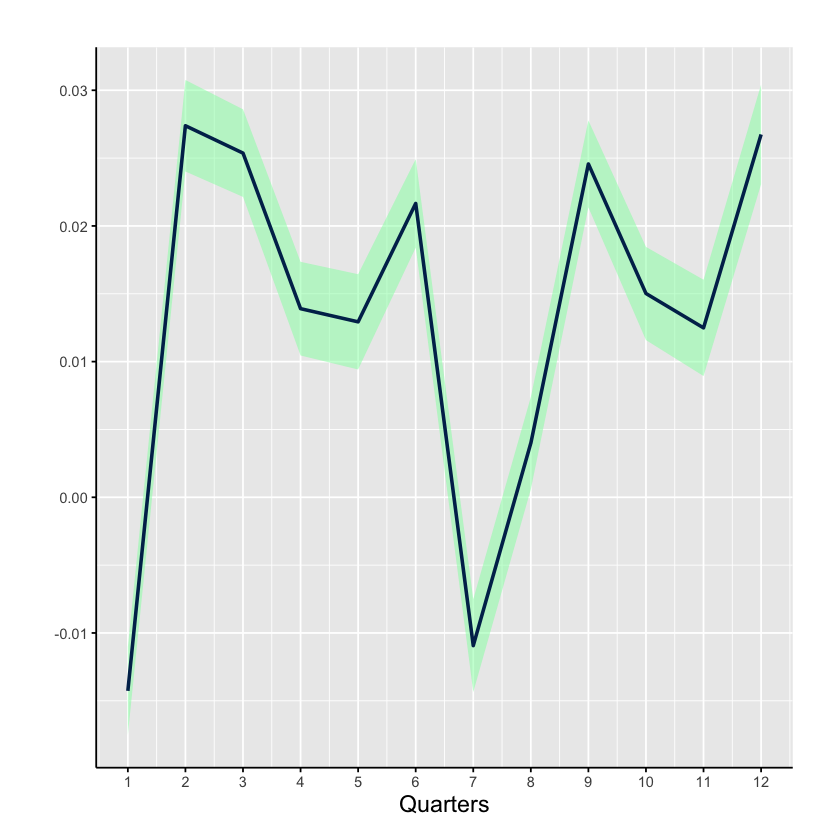

In [18]:
# shock <- c('t2m_wtd_std','tp_1000_wtd_std', 't2m_wtd_hd','tp_1000_wtd_hd','medit_factor_tp_weight'	,'medit_factor_t2m_weight' )
# l_exog_data <- c('t2m_wtd_hd', 'tp_1000_wtd_hd', 
#                 't2m_wtd_std','tp_1000_wtd_std', 'medit_factor_tp_weight'	,'medit_factor_t2m_weight')
endog        <- c("purchases_log_D1", "ur_D1", "hpi_log_D1")
shock     <-  c('fwi_D1', 'high_fire_days', 'cdd', 'extreme_precipitation_mm',
       'frequency_of_extreme_precipitation','num_heatwaves',
       'hot_days', 'num_tropical_nights', 'frost_days',  "Medit_factor_tp",
"Medit_factor_t2m_D1")

c_exog_data <- c('Quadratic_Trend' , 'Linear_Trend')                
for (endog_var in endog) {
    for (shock_var in exo_base) {
    
    # Prepare c_exog_data: endog_data without the current endog_var
    c_exog_data_endog_removed <- setdiff(endog, endog_var)
    l_exog_data_removed <- setdiff(exo_base, shock_var)
    c_exog_complete <- c(c_exog_data_endog_removed, c_exog_data)

    # Calculate lp_lin_panel
    result <- lp_lin_panel(data_set = df_tmp_df, data_sample = 'Full',  
                            endog = endog_var, shock = shock_var, 
                            diff_shock=FALSE, cumul_mult = TRUE, 
                            panel_model = "within", panel_effect = "individual", iv_reg = FALSE, instrum = FALSE, use_gmm = FALSE, 
                            c_exog_data = c_exog_complete, 
                            l_exog_data = l_exog_data_removed, 
                              lags_exog_data = 2, confint = 1.67, hor = 12)

    plot_irf <- plot_irf_lp(lp_output = result,shock_var = shock_var, endog_var = endog_var)

    print(plot_irf)
        print("endog var")
    print(endog_var)
    print(shock_var)
    #ggsave(filename = glue('lp_{endog_var}_{shock_var}.png'), plot = plot_irf, dpi = 300, width = 1500, height = 1500,units = c('px') ,path = '/Users/dhruvnovaims/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/msc-thesis/plots_paper/mm/lp_std', device = 'png')

    }
}
